# Blender Environment

## Get Tensor of noise function

In [11]:
import bpy
import bmesh
import numpy as np
import torch

def create_noise_with_colorramp():
    """Create noise setup matching your exact configuration"""
    
    # Clear existing mesh objects
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete(use_global=False, confirm=False)
    
    # Clear existing node groups
    for node_group in bpy.data.node_groups:
        bpy.data.node_groups.remove(node_group)
    
    # Create a subdivided plane
    bpy.ops.mesh.primitive_plane_add(size=2)
    plane = bpy.context.active_object
    
    # Subdivide the plane for resolution
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=63)  # 64x64 grid
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Create geometry node group (your exact setup)
    node_group = bpy.data.node_groups.new("NoiseColorRampGroup", 'GeometryNodeTree')
    
    # Add group input and output nodes
    group_input = node_group.nodes.new('NodeGroupInput')
    group_output = node_group.nodes.new('NodeGroupOutput')
    
    # Set up the interface (Blender 4.4 style)
    if hasattr(node_group, 'interface'):
        # Add input socket for geometry
        node_group.interface.new_socket(
            name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
        )
        # Add output socket for geometry
        node_group.interface.new_socket(
            name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
        )
    
    # Create nodes according to your config
    nodes_config = {
        "nodes": [
            ("noise", "ShaderNodeTexNoise"),
            ("combine", "ShaderNodeCombineXYZ"),
            ("ramp", "ShaderNodeValToRGB"),
            ("set_pos", "GeometryNodeSetPosition"),
        ],
        "connections": [
            ("noise", "Fac", "combine", "X"),
            ("noise", "Fac", "combine", "Y"), 
            ("noise", "Fac", "combine", "Z"),
            ("combine", "Vector", "ramp", "Fac"),
            ("ramp", "Color", "set_pos", "Offset"),
        ],
    }
    
    # Create the nodes
    created_nodes = {}
    for name, node_type in nodes_config["nodes"]:
        created_nodes[name] = node_group.nodes.new(node_type)
        print(f"Created {node_type} node named '{name}'")
    
    # Also need position input for the noise
    position_node = node_group.nodes.new('GeometryNodeInputPosition')
    created_nodes["position"] = position_node
    
    # Connect position to noise
    node_group.links.new(
        position_node.outputs['Position'],
        created_nodes["noise"].inputs['Vector']
    )
    
    # Create connections according to your config
    for from_node, from_out, to_node, to_in in nodes_config["connections"]:
        node_group.links.new(
            created_nodes[from_node].outputs[from_out],
            created_nodes[to_node].inputs[to_in],
        )
        print(f"Connected {from_node}.{from_out} → {to_node}.{to_in}")
    
    # Connect to group input/output
    node_group.links.new(
        group_input.outputs[0], 
        created_nodes["set_pos"].inputs["Geometry"]
    )
    node_group.links.new(
        created_nodes["set_pos"].outputs["Geometry"], 
        group_output.inputs[0]
    )
    
    # Set default noise parameters
    noise_node = created_nodes["noise"]
    noise_node.inputs['Scale'].default_value = 5.0
    noise_node.inputs['Detail'].default_value = 5.0
    noise_node.inputs['Roughness'].default_value = 0.5
    
    # Set up color ramp (default gradient)
    ramp_node = created_nodes["ramp"]
    ramp_node.color_ramp.elements[0].color = (0, 0, 0, 1)  # Black at 0
    ramp_node.color_ramp.elements[1].color = (1, 1, 1, 1)  # White at 1
    
    # Add geometry nodes modifier
    modifier = plane.modifiers.new("GeometryNodes", 'NODES')
    modifier.node_group = node_group
    
    print(f"Created noise setup with {len(node_group.links)} connections")
    
    return plane, modifier, created_nodes

def get_noise_tensor_from_colorramp(plane, resolution=64):
    """Extract height data from the color ramp setup"""
    
    # Force update
    bpy.context.view_layer.update()
    
    # Get the displaced mesh data
    depsgraph = bpy.context.evaluated_depsgraph_get()
    plane_eval = plane.evaluated_get(depsgraph)
    mesh = plane_eval.to_mesh()
    
    # Extract Z coordinates (heights) as grid
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    
    # Convert to regular grid
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    # Convert to tensor
    tensor = torch.from_numpy(heights).float()
    
    # Clean up
    plane_eval.to_mesh_clear()
    
    return tensor

def modify_noise_parameters(created_nodes, scale=5.0, detail=5.0, roughness=0.5):
    """Modify noise parameters directly on the nodes"""
    
    noise_node = created_nodes["noise"]
    
    print(f"Setting noise parameters:")
    print(f"  Scale: {scale}")
    print(f"  Detail: {detail}")
    print(f"  Roughness: {roughness}")
    
    # Update the noise node directly
    noise_node.inputs['Scale'].default_value = scale
    noise_node.inputs['Detail'].default_value = detail
    noise_node.inputs['Roughness'].default_value = roughness
    
    # Force update
    bpy.context.view_layer.update()

def modify_color_ramp(created_nodes, positions, colors):
    """Modify the color ramp points"""
    
    ramp_node = created_nodes["ramp"]
    color_ramp = ramp_node.color_ramp
    
    print(f"Updating color ramp with {len(positions)} points")
    
    # Clear existing points (keep first two)
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Update existing points and add new ones
    for i, (pos, color) in enumerate(zip(positions, colors)):
        if i < 2:
            # Update existing points
            color_ramp.elements[i].position = pos
            color_ramp.elements[i].color = color
            print(f"  Updated point {i}: pos={pos}, color={color}")
        else:
            # Add new points
            element = color_ramp.elements.new(pos)
            element.color = color
            print(f"  Added point {i}: pos={pos}, color={color}")

def test_noise_manipulation():
    """Test that we can manipulate the noise and see changes"""
    
    print("🔍 TESTING NOISE MANIPULATION (YOUR SETUP)")
    print("=" * 60)
    
    # Create the setup
    plane, modifier, nodes = create_noise_with_colorramp()
    
    # Test 1: Different noise scales
    print("\n📏 Testing different noise scales:")
    scales = [1.0, 5.0, 10.0, 20.0]
    scale_results = {}
    
    for scale in scales:
        modify_noise_parameters(nodes, scale=scale, detail=5.0, roughness=0.5)
        tensor = get_noise_tensor_from_colorramp(plane)
        scale_results[scale] = tensor
        
        print(f"  Scale {scale:4.1f}: Range [{tensor.min():6.3f}, {tensor.max():6.3f}], Std: {tensor.std():6.3f}")
    
    # Test 2: Different detail levels
    print("\n🔍 Testing different detail levels:")
    details = [2.0, 5.0, 10.0, 15.0]
    detail_results = {}
    
    for detail in details:
        modify_noise_parameters(nodes, scale=5.0, detail=detail, roughness=0.5)
        tensor = get_noise_tensor_from_colorramp(plane)
        detail_results[detail] = tensor
        
        print(f"  Detail {detail:4.1f}: Range [{tensor.min():6.3f}, {tensor.max():6.3f}], Std: {tensor.std():6.3f}")
    
    # Test 3: Different color ramps
    print("\n🌈 Testing different color ramps:")
    
    # Linear gradient (default)
    modify_color_ramp(nodes, 
                     positions=[0.0, 1.0],
                     colors=[(0, 0, 0, 1), (1, 1, 1, 1)])
    tensor_linear = get_noise_tensor_from_colorramp(plane)
    print(f"  Linear gradient: Range [{tensor_linear.min():6.3f}, {tensor_linear.max():6.3f}]")
    
    # Step function
    modify_color_ramp(nodes,
                     positions=[0.0, 0.5, 0.51, 1.0], 
                     colors=[(0, 0, 0, 1), (0, 0, 0, 1), (1, 1, 1, 1), (1, 1, 1, 1)])
    tensor_step = get_noise_tensor_from_colorramp(plane)
    print(f"  Step function: Range [{tensor_step.min():6.3f}, {tensor_step.max():6.3f}]")
    
    # Inverted gradient
    modify_color_ramp(nodes,
                     positions=[0.0, 1.0],
                     colors=[(1, 1, 1, 1), (0, 0, 0, 1)])
    tensor_inverted = get_noise_tensor_from_colorramp(plane)
    print(f"  Inverted gradient: Range [{tensor_inverted.min():6.3f}, {tensor_inverted.max():6.3f}]")
    
    # Verification tests
    print("\n✅ Verification:")
    
    # Different scales should produce different results
    diff_scales = torch.abs(scale_results[1.0] - scale_results[20.0]).mean()
    print(f"  Scale difference (1.0 vs 20.0): {diff_scales:.6f} (should be > 0)")
    
    # Different details should produce different results  
    diff_details = torch.abs(detail_results[2.0] - detail_results[15.0]).mean()
    print(f"  Detail difference (2.0 vs 15.0): {diff_details:.6f} (should be > 0)")
    
    # Different color ramps should produce different results
    diff_ramps = torch.abs(tensor_linear - tensor_step).mean()
    print(f"  Color ramp difference: {diff_ramps:.6f} (should be > 0)")
    
    # Save results
    results = {
        'scales': scale_results,
        'details': detail_results,
        'color_ramps': {
            'linear': tensor_linear,
            'step': tensor_step,
            'inverted': tensor_inverted
        },
        'verification': {
            'scale_diff': diff_scales,
            'detail_diff': diff_details,
            'ramp_diff': diff_ramps
        }
    }
    
    torch.save(results, 'noise_colorramp_results.pt')
    
    # Quick test - save the current state
    final_tensor = get_noise_tensor_from_colorramp(plane)
    np.save('blender_noise_colorramp.npy', final_tensor.numpy())
    torch.save(final_tensor, 'blender_noise_colorramp.pt')
    
    print(f"\n💾 Results saved:")
    print(f"  Full results: noise_colorramp_results.pt")
    print(f"  Final tensor: blender_noise_colorramp.npy")
    
    return results

if __name__ == "__main__":
    # Run the test
    results = test_noise_manipulation()
    
    print(f"\n🎯 FINAL SUMMARY:")
    print(f"✅ Noise parameters working: {results['verification']['scale_diff'] > 0.01}")
    print(f"✅ Detail parameters working: {results['verification']['detail_diff'] > 0.01}")
    print(f"✅ Color ramp manipulation working: {results['verification']['ramp_diff'] > 0.01}")

🔍 TESTING NOISE MANIPULATION (YOUR SETUP)
Created ShaderNodeTexNoise node named 'noise'
Created ShaderNodeCombineXYZ node named 'combine'
Created ShaderNodeValToRGB node named 'ramp'
Created GeometryNodeSetPosition node named 'set_pos'
Connected noise.Fac → combine.X
Connected noise.Fac → combine.Y
Connected noise.Fac → combine.Z
Connected combine.Vector → ramp.Fac
Connected ramp.Color → set_pos.Offset
Created noise setup with 8 connections

📏 Testing different noise scales:
Setting noise parameters:
  Scale: 1.0
  Detail: 5.0
  Roughness: 0.5
  Scale  1.0: Range [ 0.361,  0.680], Std:  0.063
Setting noise parameters:
  Scale: 5.0
  Detail: 5.0
  Roughness: 0.5
  Scale  5.0: Range [ 0.277,  0.739], Std:  0.069
Setting noise parameters:
  Scale: 10.0
  Detail: 5.0
  Roughness: 0.5
  Scale 10.0: Range [ 0.283,  0.734], Std:  0.072
Setting noise parameters:
  Scale: 20.0
  Detail: 5.0
  Roughness: 0.5
  Scale 20.0: Range [ 0.281,  0.734], Std:  0.074

🔍 Testing different detail levels:
Se

## Figures

🎨 BLENDER NOISE VISUALIZATION SUITE
1. Running comprehensive analysis...
🎨 VISUALIZING COLOR RAMP NOISE RESULTS


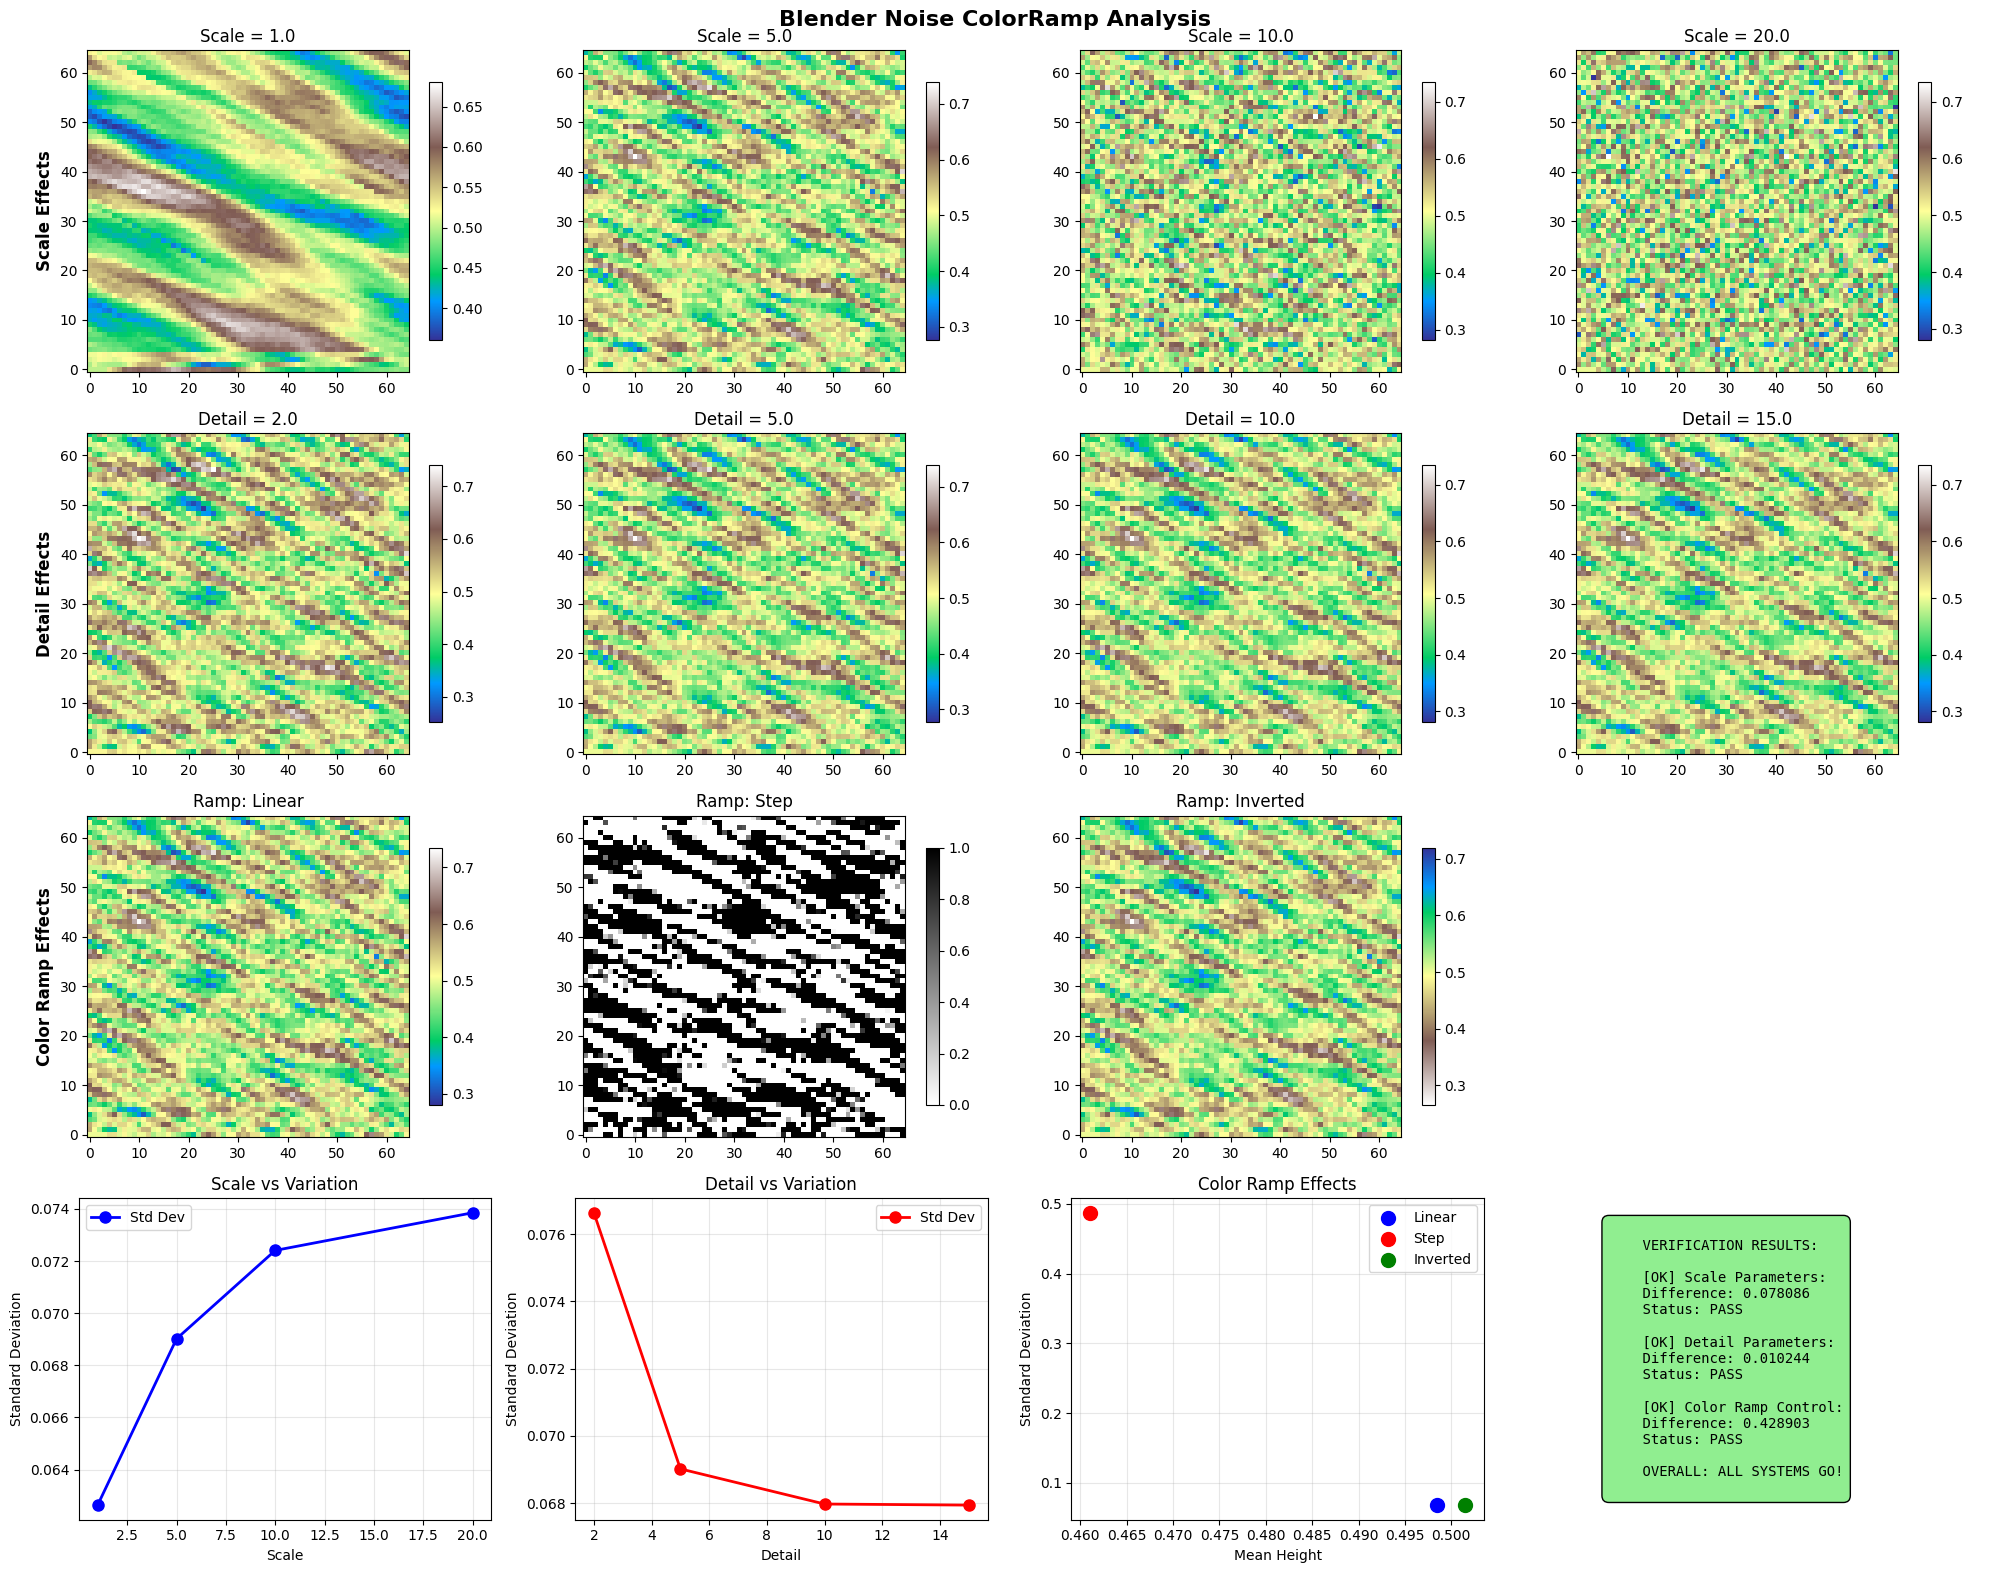


📊 ANALYSIS SUMMARY:
Scale control: [OK] WORKING
Detail control: [OK] WORKING
Color ramp control: [OK] WORKING

2. Running 3D surface comparison...


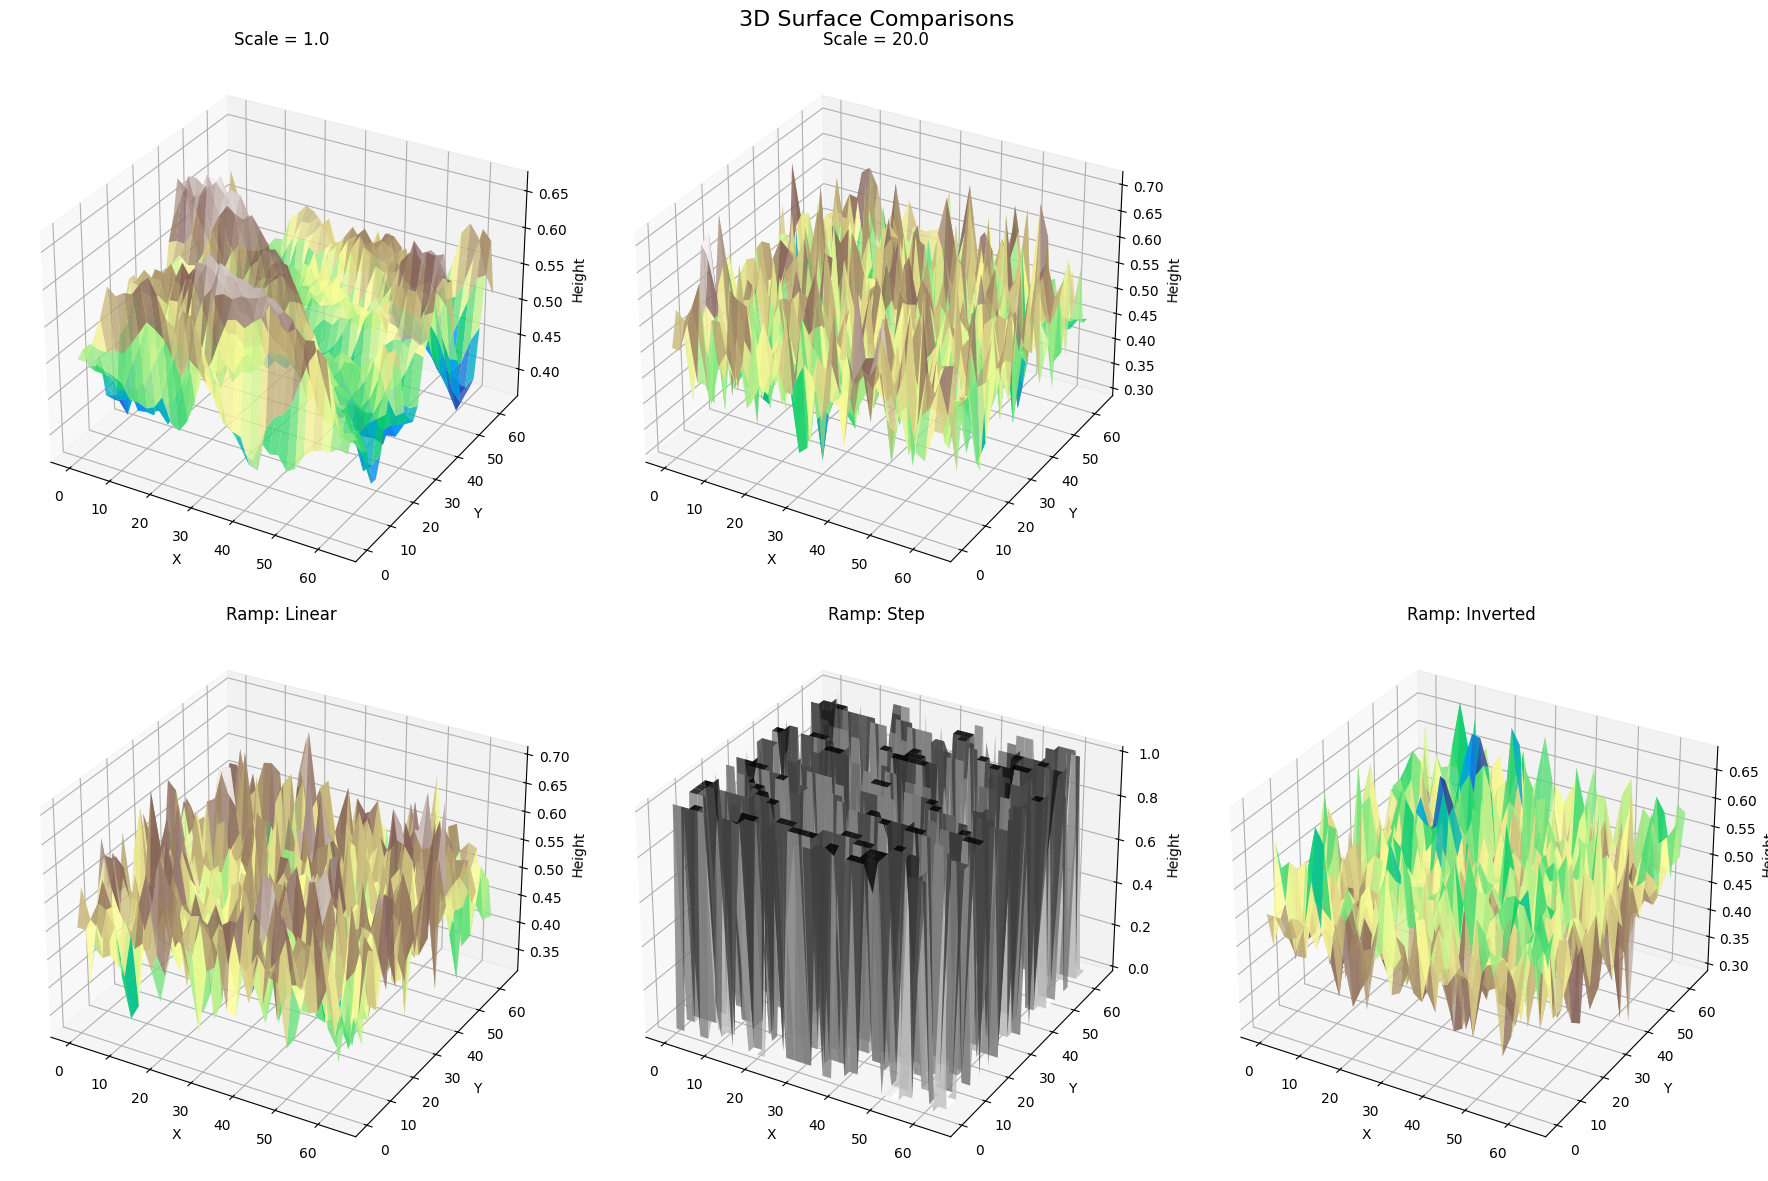


3. Running detailed characteristics analysis...


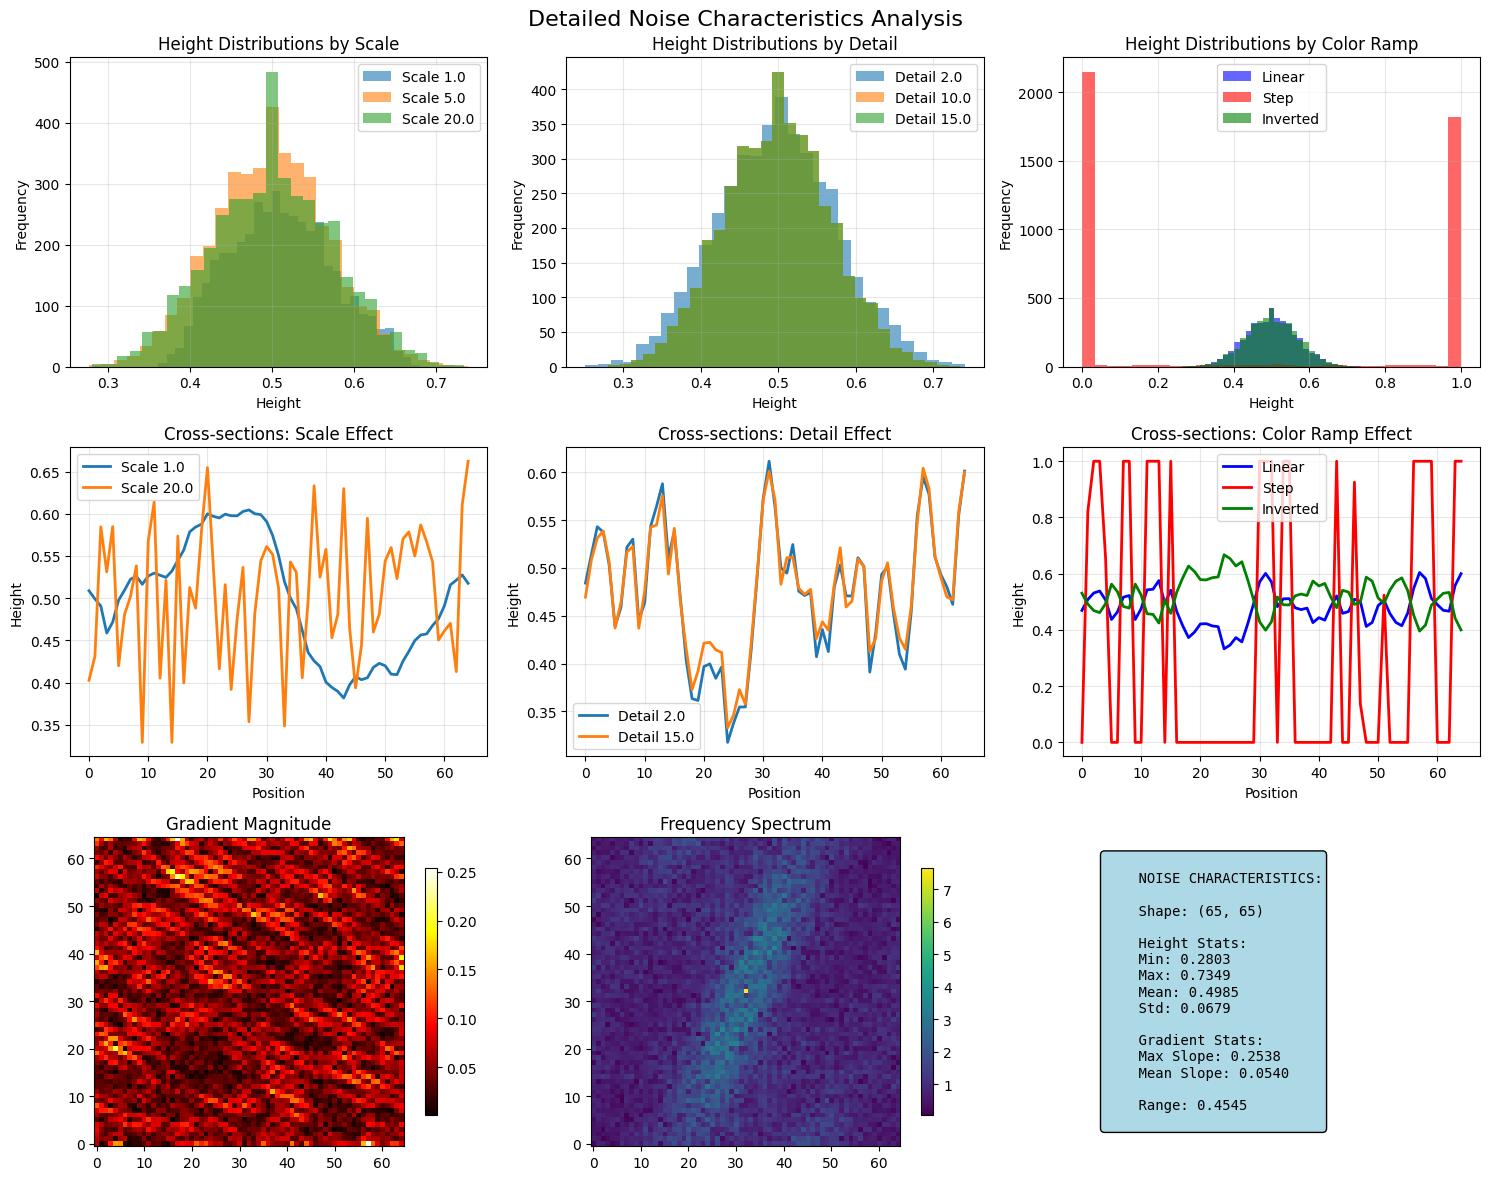


4. Running quick single sample visualization...


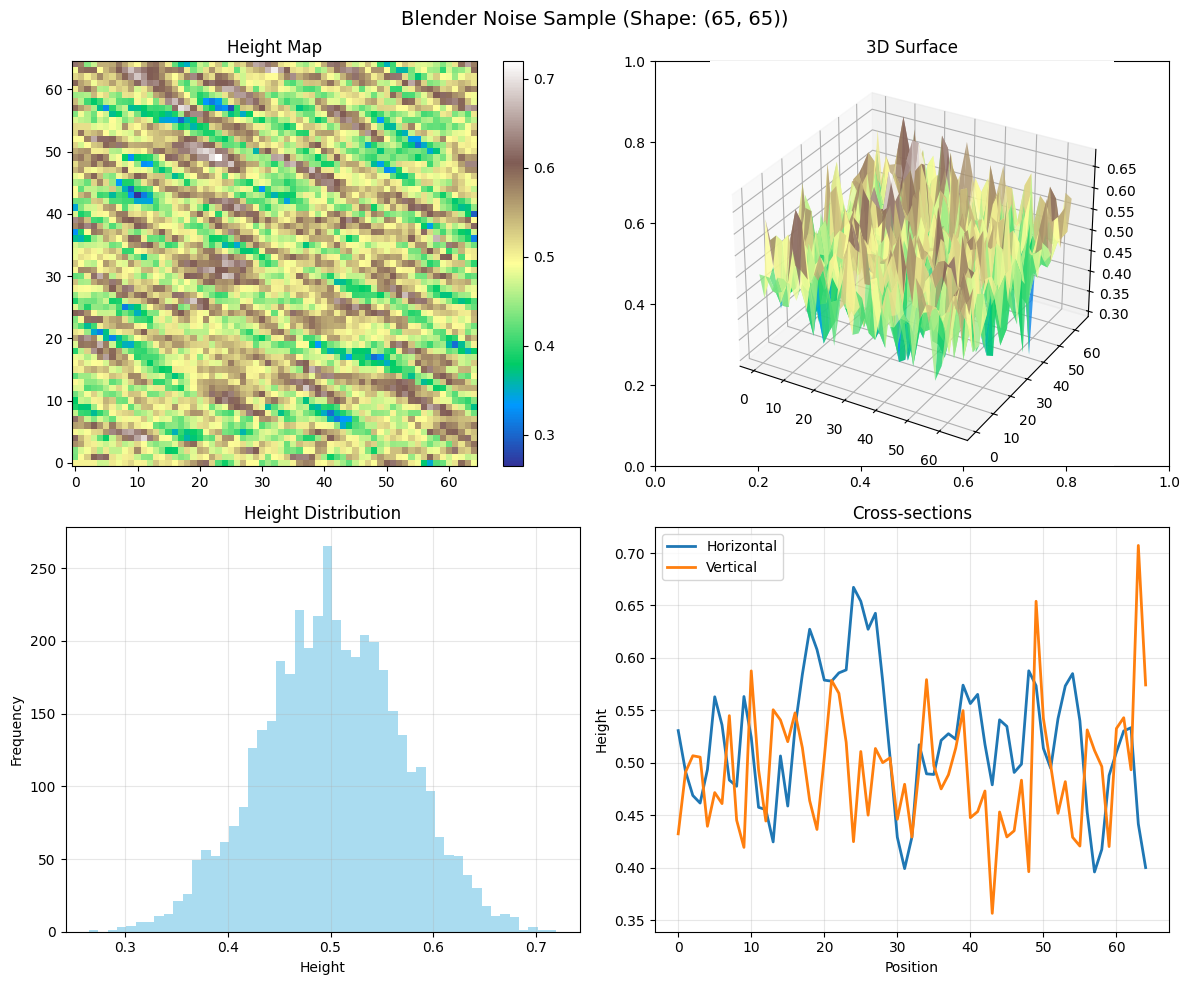

📊 Quick Stats:
Shape: (65, 65)
Range: [0.2651, 0.7197]
Mean: 0.5015
Std: 0.0679

✅ All visualizations complete!
Generated files:
  - noise_colorramp_analysis.png
  - noise_3d_comparison.png
  - noise_characteristics_analysis.png
  - quick_noise_visualization.png


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def visualize_colorramp_results():
    """Visualize the noise color ramp results"""
    
    try:
        results = torch.load('noise_colorramp_results.pt')
    except FileNotFoundError:
        print("❌ No color ramp results found!")
        print("Run the Blender color ramp script first.")
        return
    
    print("🎨 VISUALIZING COLOR RAMP NOISE RESULTS")
    print("=" * 60)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Scale comparison (top row)
    scale_results = results['scales']
    scales = list(scale_results.keys())
    
    for i, scale in enumerate(scales):
        ax = plt.subplot(4, 4, i + 1)
        noise = scale_results[scale].numpy()
        im = plt.imshow(noise, cmap='terrain', origin='lower')
        plt.title(f'Scale = {scale}')
        plt.colorbar(im, shrink=0.8)
        if i == 0:
            plt.ylabel('Scale Effects', fontsize=12, fontweight='bold')
    
    # 2. Detail comparison (second row)
    detail_results = results['details']
    details = list(detail_results.keys())
    
    for i, detail in enumerate(details):
        ax = plt.subplot(4, 4, 4 + i + 1)
        noise = detail_results[detail].numpy()
        im = plt.imshow(noise, cmap='terrain', origin='lower')
        plt.title(f'Detail = {detail}')
        plt.colorbar(im, shrink=0.8)
        if i == 0:
            plt.ylabel('Detail Effects', fontsize=12, fontweight='bold')
    
    # 3. Color ramp comparison (third row)
    ramp_results = results['color_ramps']
    ramp_names = list(ramp_results.keys())
    
    for i, ramp_name in enumerate(ramp_names):
        ax = plt.subplot(4, 4, 8 + i + 1)
        noise = ramp_results[ramp_name].numpy()
        
        # Use different colormaps to show the effect
        cmap = 'terrain' if ramp_name == 'linear' else ('binary' if ramp_name == 'step' else 'terrain_r')
        im = plt.imshow(noise, cmap=cmap, origin='lower')
        plt.title(f'Ramp: {ramp_name.title()}')
        plt.colorbar(im, shrink=0.8)
        if i == 0:
            plt.ylabel('Color Ramp Effects', fontsize=12, fontweight='bold')
    
    # 4. Statistical analysis (fourth row)
    
    # Scale effect on variation
    ax = plt.subplot(4, 4, 13)
    scale_stds = [scale_results[s].std().item() for s in scales]
    scale_means = [scale_results[s].mean().item() for s in scales]
    
    plt.plot(scales, scale_stds, 'bo-', linewidth=2, markersize=8, label='Std Dev')
    plt.xlabel('Scale')
    plt.ylabel('Standard Deviation')
    plt.title('Scale vs Variation')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Detail effect on variation
    ax = plt.subplot(4, 4, 14)
    detail_stds = [detail_results[d].std().item() for d in details]
    detail_means = [detail_results[d].mean().item() for d in details]
    
    plt.plot(details, detail_stds, 'ro-', linewidth=2, markersize=8, label='Std Dev')
    plt.xlabel('Detail')
    plt.ylabel('Standard Deviation')
    plt.title('Detail vs Variation')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Color ramp effect comparison
    ax = plt.subplot(4, 4, 15)
    ramp_stds = [ramp_results[name].std().item() for name in ramp_names]
    ramp_means = [ramp_results[name].mean().item() for name in ramp_names]
    
    colors = ['blue', 'red', 'green']
    for i, (name, std, mean) in enumerate(zip(ramp_names, ramp_stds, ramp_means)):
        plt.scatter(mean, std, c=colors[i], s=100, label=name.title())
    
    plt.xlabel('Mean Height')
    plt.ylabel('Standard Deviation')
    plt.title('Color Ramp Effects')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Verification status
    ax = plt.subplot(4, 4, 16)
    plt.axis('off')
    
    verification = results['verification']
    scale_diff = verification['scale_diff'].item()
    detail_diff = verification['detail_diff'].item()
    ramp_diff = verification['ramp_diff'].item()
    
    # Status checks
    scale_ok = scale_diff > 0.01
    detail_ok = detail_diff > 0.01
    ramp_ok = ramp_diff > 0.01
    
    status_text = f"""
    VERIFICATION RESULTS:
    
    [OK] Scale Parameters:
    Difference: {scale_diff:.6f}
    Status: {"PASS" if scale_ok else "FAIL"}
    
    [OK] Detail Parameters:
    Difference: {detail_diff:.6f}
    Status: {"PASS" if detail_ok else "FAIL"}
    
    [OK] Color Ramp Control:
    Difference: {ramp_diff:.6f}
    Status: {"PASS" if ramp_ok else "FAIL"}
    
    OVERALL: {"ALL SYSTEMS GO!" if all([scale_ok, detail_ok, ramp_ok]) else "ISSUES DETECTED"}
    """
    
    bg_color = "lightgreen" if all([scale_ok, detail_ok, ramp_ok]) else "lightcoral"
    plt.text(0.1, 0.5, status_text, fontsize=10, 
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor=bg_color))
    
    plt.suptitle('Blender Noise ColorRamp Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('noise_colorramp_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n📊 ANALYSIS SUMMARY:")
    print(f"Scale control: {'[OK] WORKING' if scale_ok else '[X] NOT WORKING'}")
    print(f"Detail control: {'[OK] WORKING' if detail_ok else '[X] NOT WORKING'}")
    print(f"Color ramp control: {'[OK] WORKING' if ramp_ok else '[X] NOT WORKING'}")

def compare_3d_surfaces():
    """Show 3D surface comparisons"""
    
    try:
        results = torch.load('noise_colorramp_results.pt')
    except FileNotFoundError:
        print("❌ No results found!")
        return
    
    fig = plt.figure(figsize=(18, 12))
    
    # Compare different scales in 3D
    scales = [1.0, 20.0]
    scale_results = results['scales']
    
    for i, scale in enumerate(scales):
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        noise = scale_results[scale].numpy()
        
        # Create coordinate grids
        x = np.arange(noise.shape[1])
        y = np.arange(noise.shape[0])
        X, Y = np.meshgrid(x, y)
        
        # Subsample for performance
        step = max(1, noise.shape[0] // 32)
        X_sub = X[::step, ::step]
        Y_sub = Y[::step, ::step]
        noise_sub = noise[::step, ::step]
        
        surf = ax.plot_surface(X_sub, Y_sub, noise_sub, cmap='terrain', alpha=0.8)
        ax.set_title(f'Scale = {scale}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
    
    # Compare different color ramps
    ramp_results = results['color_ramps']
    ramp_names = ['linear', 'step', 'inverted']
    
    for i, ramp_name in enumerate(ramp_names):
        ax = fig.add_subplot(2, 3, 3 + i + 1, projection='3d')
        noise = ramp_results[ramp_name].numpy()
        
        x = np.arange(noise.shape[1])
        y = np.arange(noise.shape[0])
        X, Y = np.meshgrid(x, y)
        
        step = max(1, noise.shape[0] // 32)
        X_sub = X[::step, ::step]
        Y_sub = Y[::step, ::step]
        noise_sub = noise[::step, ::step]
        
        cmap = 'terrain' if ramp_name == 'linear' else ('binary' if ramp_name == 'step' else 'terrain_r')
        surf = ax.plot_surface(X_sub, Y_sub, noise_sub, cmap=cmap, alpha=0.8)
        ax.set_title(f'Ramp: {ramp_name.title()}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
    
    plt.suptitle('3D Surface Comparisons', fontsize=16)
    plt.tight_layout()
    plt.savefig('noise_3d_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

def analyze_noise_characteristics():
    """Detailed analysis of noise characteristics"""
    
    try:
        results = torch.load('noise_colorramp_results.pt')
    except FileNotFoundError:
        print("❌ No results found!")
        return
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # 1. Height distributions for different scales
    scale_results = results['scales']
    ax = axes[0, 0]
    for scale in [1.0, 5.0, 20.0]:
        noise = scale_results[scale].numpy().flatten()
        ax.hist(noise, bins=30, alpha=0.6, label=f'Scale {scale}')
    ax.set_title('Height Distributions by Scale')
    ax.set_xlabel('Height')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Height distributions for different details
    detail_results = results['details']
    ax = axes[0, 1]
    for detail in [2.0, 10.0, 15.0]:
        noise = detail_results[detail].numpy().flatten()
        ax.hist(noise, bins=30, alpha=0.6, label=f'Detail {detail}')
    ax.set_title('Height Distributions by Detail')
    ax.set_xlabel('Height')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Color ramp effect on distributions
    ramp_results = results['color_ramps']
    ax = axes[0, 2]
    colors = ['blue', 'red', 'green']
    for i, (name, color) in enumerate(zip(['linear', 'step', 'inverted'], colors)):
        noise = ramp_results[name].numpy().flatten()
        ax.hist(noise, bins=30, alpha=0.6, label=name.title(), color=color)
    ax.set_title('Height Distributions by Color Ramp')
    ax.set_xlabel('Height')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Cross-sections for scale comparison
    ax = axes[1, 0]
    for scale in [1.0, 20.0]:
        noise = scale_results[scale].numpy()
        mid_row = noise[noise.shape[0] // 2, :]
        ax.plot(mid_row, label=f'Scale {scale}', linewidth=2)
    ax.set_title('Cross-sections: Scale Effect')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Cross-sections for detail comparison
    ax = axes[1, 1]
    for detail in [2.0, 15.0]:
        noise = detail_results[detail].numpy()
        mid_row = noise[noise.shape[0] // 2, :]
        ax.plot(mid_row, label=f'Detail {detail}', linewidth=2)
    ax.set_title('Cross-sections: Detail Effect')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Cross-sections for color ramp comparison
    ax = axes[1, 2]
    colors = ['blue', 'red', 'green']
    for i, (name, color) in enumerate(zip(['linear', 'step', 'inverted'], colors)):
        noise = ramp_results[name].numpy()
        mid_row = noise[noise.shape[0] // 2, :]
        ax.plot(mid_row, label=name.title(), linewidth=2, color=color)
    ax.set_title('Cross-sections: Color Ramp Effect')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 7. Gradient analysis
    ax = axes[2, 0]
    linear_noise = ramp_results['linear'].numpy()
    gy, gx = np.gradient(linear_noise)
    gradient_mag = np.sqrt(gx**2 + gy**2)
    im = ax.imshow(gradient_mag, cmap='hot', origin='lower')
    ax.set_title('Gradient Magnitude')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 8. Frequency analysis (2D FFT)
    ax = axes[2, 1]
    fft = np.fft.fft2(linear_noise)
    fft_mag = np.log(np.abs(np.fft.fftshift(fft)) + 1)
    im = ax.imshow(fft_mag, cmap='viridis', origin='lower')
    ax.set_title('Frequency Spectrum')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 9. Statistics summary
    ax = axes[2, 2]
    ax.axis('off')
    
    # Calculate some statistics
    linear_noise = ramp_results['linear'].numpy()
    stats_text = f"""
    NOISE CHARACTERISTICS:
    
    Shape: {linear_noise.shape}
    
    Height Stats:
    Min: {linear_noise.min():.4f}
    Max: {linear_noise.max():.4f}
    Mean: {linear_noise.mean():.4f}
    Std: {linear_noise.std():.4f}
    
    Gradient Stats:
    Max Slope: {gradient_mag.max():.4f}
    Mean Slope: {gradient_mag.mean():.4f}
    
    Range: {linear_noise.max() - linear_noise.min():.4f}
    """
    
    ax.text(0.1, 0.5, stats_text, fontsize=10,
            verticalalignment='center', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.suptitle('Detailed Noise Characteristics Analysis', fontsize=16)
    plt.tight_layout()
    plt.savefig('noise_characteristics_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

def quick_single_visualization():
    """Quick visualization of a single noise sample"""
    
    try:
        # Try to load the single sample
        noise = np.load('blender_noise_colorramp.npy')
    except FileNotFoundError:
        print("❌ No single noise sample found!")
        print("Run the Blender script first to generate 'blender_noise_colorramp.npy'")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Height map
    im1 = axes[0, 0].imshow(noise, cmap='terrain', origin='lower')
    axes[0, 0].set_title('Height Map')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # 3D surface (subsampled)
    ax_3d = fig.add_subplot(2, 2, 2, projection='3d')
    step = max(1, noise.shape[0] // 32)
    x = np.arange(0, noise.shape[1], step)
    y = np.arange(0, noise.shape[0], step)
    X, Y = np.meshgrid(x, y)
    Z = noise[::step, ::step]
    
    surf = ax_3d.plot_surface(X, Y, Z, cmap='terrain', alpha=0.8)
    ax_3d.set_title('3D Surface')
    
    # Height distribution
    axes[1, 0].hist(noise.flatten(), bins=50, alpha=0.7, color='skyblue')
    axes[1, 0].set_title('Height Distribution')
    axes[1, 0].set_xlabel('Height')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Cross-section
    mid_row = noise[noise.shape[0] // 2, :]
    mid_col = noise[:, noise.shape[1] // 2]
    axes[1, 1].plot(mid_row, label='Horizontal', linewidth=2)
    axes[1, 1].plot(mid_col, label='Vertical', linewidth=2)
    axes[1, 1].set_title('Cross-sections')
    axes[1, 1].set_xlabel('Position')
    axes[1, 1].set_ylabel('Height')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Blender Noise Sample (Shape: {noise.shape})', fontsize=14)
    plt.tight_layout()
    plt.savefig('quick_noise_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Quick Stats:")
    print(f"Shape: {noise.shape}")
    print(f"Range: [{noise.min():.4f}, {noise.max():.4f}]")
    print(f"Mean: {noise.mean():.4f}")
    print(f"Std: {noise.std():.4f}")

if __name__ == "__main__":
    print("🎨 BLENDER NOISE VISUALIZATION SUITE")
    print("=" * 60)
    
    # Try comprehensive analysis first
    print("1. Running comprehensive analysis...")
    visualize_colorramp_results()
    
    print("\n2. Running 3D surface comparison...")
    compare_3d_surfaces()
    
    print("\n3. Running detailed characteristics analysis...")
    analyze_noise_characteristics()
    
    print("\n4. Running quick single sample visualization...")
    quick_single_visualization()
    
    print("\n✅ All visualizations complete!")
    print("Generated files:")
    print("  - noise_colorramp_analysis.png")
    print("  - noise_3d_comparison.png")
    print("  - noise_characteristics_analysis.png")
    print("  - quick_noise_visualization.png")

# hole detection 

🚀 EXAMPLE: BLOB HOLE DETECTION
✓ Loaded Blender noise: (65, 65)

1️⃣ Single threshold test:
🔍 BLOB HOLE DETECTION
Noise shape: (65, 65)
Noise range: [0.2651, 0.7197]
Threshold: 0.5354
White pixels (above threshold): 1336/4225 (31.6%)
Found 167 separate blob(s)
  Blob 1: 4 pixels, no holes ✓
  Blob 2: 1 pixels, no holes ✓
  Blob 3: 7 pixels, no holes ✓
  Blob 4: 14 pixels, no holes ✓
  Blob 5: 2 pixels, no holes ✓
  Blob 6: 3 pixels, no holes ✓
  Blob 7: 1 pixels, no holes ✓
  Blob 8: 1 pixels, no holes ✓
  Blob 9: 2 pixels, no holes ✓
  Blob 10: 1 pixels, no holes ✓
  Blob 11: 2 pixels, no holes ✓
  Blob 12: 4 pixels, no holes ✓
  Blob 13: 4 pixels, no holes ✓
  Blob 14: 124 pixels, 1 hole pixels ❌
  Blob 15: 4 pixels, no holes ✓
  Blob 16: 3 pixels, no holes ✓
  Blob 17: 3 pixels, no holes ✓
  Blob 18: 1 pixels, no holes ✓
  Blob 19: 1 pixels, no holes ✓
  Blob 20: 1 pixels, no holes ✓
  Blob 21: 18 pixels, no holes ✓
  Blob 22: 10 pixels, no holes ✓
  Blob 23: 1 pixels, no holes ✓
  

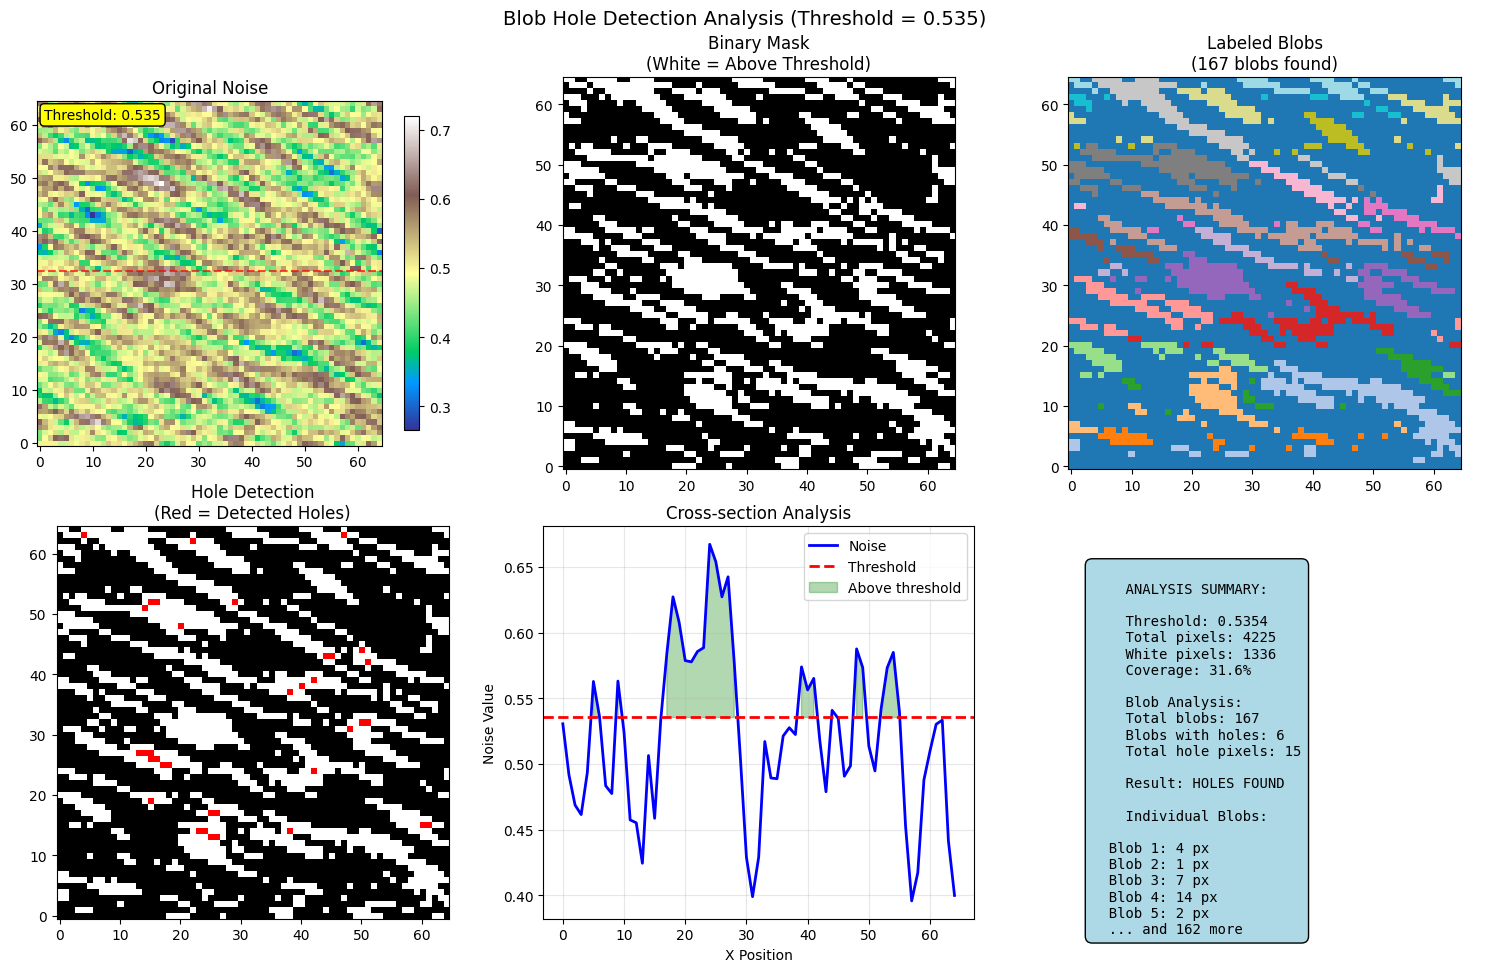

Single test result: Holes detected

2️⃣ Multiple threshold test:
🧪 TESTING MULTIPLE THRESHOLDS
Thresholds: ['0.311', '0.371', '0.432', '0.492', '0.553', '0.614', '0.674']

📍 Test 1/7 - Threshold: 0.3106
----------------------------------------
🔍 BLOB HOLE DETECTION
Noise shape: (65, 65)
Noise range: [0.2651, 0.7197]
Threshold: 0.3106
White pixels (above threshold): 4216/4225 (99.8%)
Found 1 separate blob(s)
  Blob 1: 4216 pixels, 8 hole pixels ❌

RESULT:
  Detection method: Holes detected
  Contour method: Holes detected
  Final: ❌ HOLES DETECTED
Result: ❌ HOLES FOUND

📍 Test 2/7 - Threshold: 0.3712
----------------------------------------
🔍 BLOB HOLE DETECTION
Noise shape: (65, 65)
Noise range: [0.2651, 0.7197]
Threshold: 0.3712
White pixels (above threshold): 4104/4225 (97.1%)
Found 1 separate blob(s)
  Blob 1: 4104 pixels, 110 hole pixels ❌

RESULT:
  Detection method: Holes detected
  Contour method: Holes detected
  Final: ❌ HOLES DETECTED
Result: ❌ HOLES FOUND

📍 Test 3/7 - Thres

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology, measure
import cv2

def detect_holes_in_blobs(noise_tensor, threshold, visualize=True):
    """
    Take noise function and threshold to create binary mask,
    then detect if there are holes in the white blobs.
    
    Args:
        noise_tensor: 2D tensor/array of noise values
        threshold: threshold value to binarize the noise
        visualize: whether to show visualization
    
    Returns:
        bool: True if NO holes are found in blobs, False if holes exist
    """
    
    # Convert to numpy if tensor
    if torch.is_tensor(noise_tensor):
        noise = noise_tensor.numpy()
    else:
        noise = noise_tensor
    
    print(f"🔍 BLOB HOLE DETECTION")
    print(f"Noise shape: {noise.shape}")
    print(f"Noise range: [{noise.min():.4f}, {noise.max():.4f}]")
    print(f"Threshold: {threshold:.4f}")
    
    # Create binary mask: white (True) for values above threshold
    binary_mask = noise > threshold
    white_pixels = binary_mask.sum()
    total_pixels = binary_mask.size
    
    print(f"White pixels (above threshold): {white_pixels}/{total_pixels} ({100*white_pixels/total_pixels:.1f}%)")
    
    if white_pixels == 0:
        print("❌ No white pixels found - threshold too high")
        return True  # No blobs = no holes
    
    # Find connected components (blobs)
    labeled_blobs, num_blobs = ndimage.label(binary_mask)
    print(f"Found {num_blobs} separate blob(s)")
    
    if num_blobs == 0:
        return True  # No blobs = no holes
    
    # Check each blob for holes
    holes_found = False
    blob_info = []
    
    for blob_id in range(1, num_blobs + 1):
        # Extract single blob
        single_blob = (labeled_blobs == blob_id)
        blob_size = single_blob.sum()
        
        # Method 1: Detect holes by checking what would be filled
        # Compare original blob with what it would look like if holes were filled
        would_be_filled = ndimage.binary_fill_holes(single_blob)
        hole_pixels = would_be_filled.sum() - blob_size  # How many pixels would be added
        has_holes = hole_pixels > 0
        
        blob_info.append({
            'id': blob_id,
            'size': blob_size,
            'hole_pixels': hole_pixels,
            'has_holes': has_holes
        })
        
        if has_holes:
            holes_found = True
            print(f"  Blob {blob_id}: {blob_size} pixels, {hole_pixels} hole pixels ❌")
        else:
            print(f"  Blob {blob_id}: {blob_size} pixels, no holes ✓")
    
    # Alternative method using contours (more robust)
    holes_found_contour = check_holes_with_contours(binary_mask.astype(np.uint8))
    
    # Final result - use more conservative approach
    final_result = not (holes_found or holes_found_contour)
    
    print(f"\nRESULT:")
    print(f"  Detection method: {'No holes' if not holes_found else 'Holes detected'}")
    print(f"  Contour method: {'No holes' if not holes_found_contour else 'Holes detected'}")
    print(f"  Final: {'✓ NO HOLES' if final_result else '❌ HOLES DETECTED'}")
    
    if visualize:
        visualize_blob_analysis(noise, threshold, binary_mask, labeled_blobs, blob_info)
    
    return final_result

def check_holes_with_contours(binary_mask):
    """Alternative hole detection using OpenCV contours"""
    
    try:
        # Find contours
        contours, hierarchy = cv2.findContours(
            binary_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
        )
        
        if hierarchy is None:
            return False
        
        # Check hierarchy for holes
        # In RETR_CCOMP: hierarchy[i] = [next, prev, first_child, parent]
        # If first_child != -1, this contour has holes
        holes_found = False
        for i, h in enumerate(hierarchy[0]):
            if h[2] != -1:  # has child contour (hole)
                holes_found = True
                break
        
        return holes_found
        
    except Exception as e:
        print(f"Contour method failed: {e}")
        return False

def visualize_blob_analysis(noise, threshold, binary_mask, labeled_blobs, blob_info):
    """Visualize the blob analysis process"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Original noise
    im1 = axes[0, 0].imshow(noise, cmap='terrain', origin='lower')
    axes[0, 0].axhline(y=noise.shape[0]/2, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Original Noise')
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)
    
    # Add threshold line to colorbar area
    axes[0, 0].text(0.02, 0.98, f'Threshold: {threshold:.3f}', 
                   transform=axes[0, 0].transAxes, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"),
                   verticalalignment='top')
    
    # 2. Binary mask
    axes[0, 1].imshow(binary_mask, cmap='gray', origin='lower')
    axes[0, 1].set_title('Binary Mask\n(White = Above Threshold)')
    
    # 3. Labeled blobs
    axes[0, 2].imshow(labeled_blobs, cmap='tab20', origin='lower')
    axes[0, 2].set_title(f'Labeled Blobs\n({len(blob_info)} blobs found)')
    
    # 4. Hole detection visualization
    # Show where holes would be (for visualization only - we're not filling them!)
    would_be_filled = ndimage.binary_fill_holes(binary_mask)
    hole_locations = would_be_filled & ~binary_mask  # Where holes are located
    
    # Create RGB image to show original + detected hole locations
    rgb_image = np.zeros((*binary_mask.shape, 3))
    rgb_image[binary_mask] = [1, 1, 1]      # White for original blobs
    rgb_image[hole_locations] = [1, 0, 0]   # Red for detected hole locations
    
    axes[1, 0].imshow(rgb_image, origin='lower')
    axes[1, 0].set_title('Hole Detection\n(Red = Detected Holes)')
    
    # 5. Cross-section analysis
    mid_row = noise[noise.shape[0] // 2, :]
    x_coords = np.arange(len(mid_row))
    
    axes[1, 1].plot(x_coords, mid_row, 'b-', linewidth=2, label='Noise')
    axes[1, 1].axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[1, 1].fill_between(x_coords, threshold, mid_row, 
                           where=(mid_row > threshold), alpha=0.3, color='green', label='Above threshold')
    axes[1, 1].set_title('Cross-section Analysis')
    axes[1, 1].set_xlabel('X Position')
    axes[1, 1].set_ylabel('Noise Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Statistics summary
    axes[1, 2].axis('off')
    
    total_holes = sum([info['hole_pixels'] for info in blob_info])
    blobs_with_holes = sum([1 for info in blob_info if info['has_holes']])
    
    stats_text = f"""
    ANALYSIS SUMMARY:
    
    Threshold: {threshold:.4f}
    Total pixels: {binary_mask.size}
    White pixels: {binary_mask.sum()}
    Coverage: {100*binary_mask.sum()/binary_mask.size:.1f}%
    
    Blob Analysis:
    Total blobs: {len(blob_info)}
    Blobs with holes: {blobs_with_holes}
    Total hole pixels: {total_holes}
    
    Result: {"NO HOLES" if total_holes == 0 else "HOLES FOUND"}
    
    Individual Blobs:
    """
    
    for info in blob_info[:5]:  # Show first 5 blobs
        stats_text += f"\n  Blob {info['id']}: {info['size']} px"
        if info['has_holes']:
            stats_text += f" ({info['hole_pixels']} holes)"
    
    if len(blob_info) > 5:
        stats_text += f"\n  ... and {len(blob_info)-5} more"
    
    axes[1, 2].text(0.1, 0.9, stats_text, fontsize=10,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue"))
    
    plt.suptitle(f'Blob Hole Detection Analysis (Threshold = {threshold:.3f})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'blob_analysis_thresh_{threshold:.3f}.png', dpi=150, bbox_inches='tight')
    plt.show()

def test_different_thresholds(noise_tensor, thresholds=None):
    """Test hole detection across multiple threshold values"""
    
    if thresholds is None:
        # Auto-generate thresholds based on noise range
        if torch.is_tensor(noise_tensor):
            noise = noise_tensor.numpy()
        else:
            noise = noise_tensor
            
        min_val, max_val = noise.min(), noise.max()
        thresholds = np.linspace(min_val + 0.1*(max_val-min_val), 
                                max_val - 0.1*(max_val-min_val), 
                                7)
    
    print(f"🧪 TESTING MULTIPLE THRESHOLDS")
    print(f"Thresholds: {[f'{t:.3f}' for t in thresholds]}")
    print("=" * 60)
    
    results = []
    
    for i, thresh in enumerate(thresholds):
        print(f"\n📍 Test {i+1}/{len(thresholds)} - Threshold: {thresh:.4f}")
        print("-" * 40)
        
        no_holes = detect_holes_in_blobs(noise_tensor, thresh, visualize=False)
        
        results.append({
            'threshold': thresh,
            'no_holes': no_holes,
            'status': 'PASS' if no_holes else 'FAIL'
        })
        
        print(f"Result: {'✓ NO HOLES' if no_holes else '❌ HOLES FOUND'}")
    
    # Summary
    print(f"\n📊 THRESHOLD TEST SUMMARY:")
    print("=" * 60)
    
    for result in results:
        status_symbol = "✓" if result['no_holes'] else "❌"
        print(f"Threshold {result['threshold']:.4f}: {status_symbol} {result['status']}")
    
    # Find good thresholds
    good_thresholds = [r['threshold'] for r in results if r['no_holes']]
    
    if good_thresholds:
        print(f"\n🎯 GOOD THRESHOLDS (no holes): {len(good_thresholds)}/{len(thresholds)}")
        print(f"Range: [{min(good_thresholds):.4f}, {max(good_thresholds):.4f}]")
    else:
        print(f"\n⚠️  NO THRESHOLDS FOUND WITHOUT HOLES")
    
    return results

# Example usage and testing
def example_usage():
    """Example of how to use the hole detection function"""
    
    print("🚀 EXAMPLE: BLOB HOLE DETECTION")
    print("=" * 50)
    
    # Load your noise data
    try:
        # Try to load from your Blender output
        noise = np.load('blender_noise_colorramp.npy')
        print(f"✓ Loaded Blender noise: {noise.shape}")
    except FileNotFoundError:
        # Generate synthetic noise for demo
        print("! No Blender noise found, generating synthetic data")
        noise = np.random.random((64, 64)) * 0.5 + 0.25
        # Add some structure
        x, y = np.mgrid[0:64, 0:64]
        noise += 0.3 * np.exp(-((x-32)**2 + (y-32)**2) / 200)
    
    # Test single threshold
    print(f"\n1️⃣ Single threshold test:")
    threshold = np.mean(noise) + 0.5 * np.std(noise)
    result = detect_holes_in_blobs(noise, threshold, visualize=True)
    print(f"Single test result: {'No holes found' if result else 'Holes detected'}")
    
    # Test multiple thresholds
    print(f"\n2️⃣ Multiple threshold test:")
    test_results = test_different_thresholds(noise)
    
    return result, test_results

if __name__ == "__main__":
    # Run the example
    result, test_results = example_usage()

## Blender Actions

In [16]:
import numpy as np
import torch
import bpy
from typing import Dict, List, Tuple, Optional

class BlenderColorRampEnvironment:
    """
    Blender environment for building color ramps through sequential actions.
    
    Action Space:
    - First action: Choose noise scale from predefined values
    - Subsequent actions: Add colors (1-32) at available positions (1/n, 2/n, ..., n/n)
    """
    
    def __init__(self, 
                 max_colors: int = 5,
                 num_color_choices: int = 32,
                 available_scales: List[float] = None,
                 plane_name: str = "Plane",
                 modifier_name: str = "GeometryNodes"):
        
        self.max_colors = max_colors
        self.num_color_choices = num_color_choices  # 32 possible colors
        self.plane_name = plane_name
        self.modifier_name = modifier_name
        
        # Default noise scales if not provided
        if available_scales is None:
            self.available_scales = [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]
        else:
            self.available_scales = available_scales
        
        # State tracking
        self.reset()
        
        # Blender objects (set when environment is initialized)
        self.plane = None
        self.modifier = None
        self.created_nodes = None
        
        print(f"🎮 Blender ColorRamp Environment initialized:")
        print(f"  Max colors: {max_colors}")
        print(f"  Color choices: {num_color_choices}")
        print(f"  Available scales: {len(self.available_scales)}")
        print(f"  Position slots: {max_colors}")
    
    def reset(self) -> Dict:
        """Reset environment to initial state"""
        
        self.step_count = 0
        self.scale_chosen = False
        self.noise_scale = None
        
        # Color ramp state: position -> color_id
        # Positions are at 1/n, 2/n, 3/n, ..., n/n where n = max_colors
        self.color_positions = {}  # {position_index: color_id}
        self.occupied_positions = set()
        
        # Available positions (0, 1, 2, ..., max_colors-1 corresponding to 1/n, 2/n, ..., n/n)
        self.available_positions = set(range(self.max_colors))
        
        self.done = False
        
        return self.get_state()
    
    def get_action_space_info(self) -> Dict:
        """Get information about the action space"""
        
        if not self.scale_chosen:
            # First action: choose scale
            return {
                'action_type': 'choose_scale',
                'num_actions': len(self.available_scales),
                'available_scales': self.available_scales,
                'description': f'Choose noise scale from {len(self.available_scales)} options'
            }
        else:
            # Subsequent actions: add color at position
            num_position_color_combinations = len(self.available_positions) * self.num_color_choices
            return {
                'action_type': 'add_color',
                'num_actions': num_position_color_combinations,
                'available_positions': list(self.available_positions),
                'num_color_choices': self.num_color_choices,
                'description': f'Choose from {len(self.available_positions)} positions × {self.num_color_choices} colors = {num_position_color_combinations} actions'
            }
    
    def get_state(self) -> Dict:
        """Get current environment state"""
        
        return {
            'step_count': self.step_count,
            'scale_chosen': self.scale_chosen,
            'noise_scale': self.noise_scale,
            'color_positions': self.color_positions.copy(),
            'occupied_positions': list(self.occupied_positions),
            'available_positions': list(self.available_positions),
            'colors_placed': len(self.color_positions),
            'max_colors': self.max_colors,
            'done': self.done
        }
    
    def action_to_scale(self, action: int) -> float:
        """Convert action index to scale value"""
        if 0 <= action < len(self.available_scales):
            return self.available_scales[action]
        else:
            raise ValueError(f"Invalid scale action {action}, must be 0-{len(self.available_scales)-1}")
    
    def action_to_position_color(self, action: int) -> Tuple[int, int]:
        """Convert action index to (position_index, color_id)"""
        if len(self.available_positions) == 0:
            raise ValueError("No available positions for color placement")
        
        num_positions = len(self.available_positions)
        position_idx = action // self.num_color_choices
        color_id = action % self.num_color_choices
        
        if position_idx >= num_positions:
            raise ValueError(f"Invalid action {action}: position index {position_idx} >= {num_positions}")
        
        # Convert to actual position index
        available_pos_list = sorted(list(self.available_positions))
        actual_position = available_pos_list[position_idx]
        
        return actual_position, color_id
    
    def position_index_to_normalized(self, position_index: int) -> float:
        """Convert position index to normalized position (0.0 to 1.0)"""
        return (position_index + 1) / self.max_colors
    
    def color_id_to_rgb(self, color_id: int) -> Tuple[float, float, float, float]:
        """Convert color ID (0-31) to RGBA values"""
        
        # Create 32 distinct colors
        if color_id == 0:
            return (0.0, 0.0, 0.0, 1.0)  # Black
        elif color_id == 1:
            return (1.0, 1.0, 1.0, 1.0)  # White
        elif color_id < 8:
            # Primary colors
            colors = [
                (1.0, 0.0, 0.0, 1.0),  # Red
                (0.0, 1.0, 0.0, 1.0),  # Green
                (0.0, 0.0, 1.0, 1.0),  # Blue
                (1.0, 1.0, 0.0, 1.0),  # Yellow
                (1.0, 0.0, 1.0, 1.0),  # Magenta
                (0.0, 1.0, 1.0, 1.0),  # Cyan
            ]
            return colors[color_id - 2]
        else:
            # Generate systematic colors for remaining IDs
            # Use HSV color space for better distribution
            hue = ((color_id - 8) / (32 - 8)) * 360
            saturation = 0.8 if color_id % 2 == 0 else 1.0
            value = 0.9 if color_id % 3 == 0 else 0.7
            
            # Convert HSV to RGB (simple approximation)
            import colorsys
            r, g, b = colorsys.hsv_to_rgb(hue/360, saturation, value)
            return (r, g, b, 1.0)
    
    def step(self, action: int) -> Tuple[Dict, float, bool, Dict]:
        """
        Take an action in the environment
        
        Returns:
            state, reward, done, info
        """
        
        if self.done:
            raise ValueError("Environment is done, call reset() first")
        
        info = {'action_taken': action}
        
        try:
            if not self.scale_chosen:
                # First action: choose scale
                self.noise_scale = self.action_to_scale(action)
                self.scale_chosen = True
                info['scale_chosen'] = self.noise_scale
                
                # Apply scale to Blender
                if self.created_nodes:
                    self._apply_noise_scale(self.noise_scale)
                
                print(f"🎛️ Step {self.step_count}: Chose noise scale {self.noise_scale}")
                
            else:
                # Subsequent actions: add color at position
                position_idx, color_id = self.action_to_position_color(action)
                
                if position_idx not in self.available_positions:
                    # Invalid action - position already occupied
                    info['error'] = f'Position {position_idx} already occupied'
                    return self.get_state(), -1.0, self.done, info
                
                # Add color to position
                self.color_positions[position_idx] = color_id
                self.occupied_positions.add(position_idx)
                self.available_positions.remove(position_idx)
                
                # Apply to Blender
                if self.created_nodes:
                    self._apply_color_ramp()
                
                normalized_pos = self.position_index_to_normalized(position_idx)
                rgba = self.color_id_to_rgb(color_id)
                
                print(f"🎨 Step {self.step_count}: Added color {color_id} (RGBA={rgba[:3]}) at position {normalized_pos:.3f}")
                
                info['position_added'] = position_idx
                info['color_added'] = color_id
                info['normalized_position'] = normalized_pos
                info['rgba'] = rgba
            
            self.step_count += 1
            
            # Check if done (all positions filled or max steps reached)
            if len(self.available_positions) == 0 or self.step_count >= self.max_colors + 1:
                self.done = True
            
            # Calculate reward (placeholder - implement your reward function)
            reward = self._calculate_reward()
            
            return self.get_state(), reward, self.done, info
            
        except Exception as e:
            info['error'] = str(e)
            return self.get_state(), -1.0, self.done, info
    
    def _apply_noise_scale(self, scale: float):
        """Apply noise scale to Blender"""
        if 'noise' in self.created_nodes:
            noise_node = self.created_nodes['noise']
            noise_node.inputs['Scale'].default_value = scale
            bpy.context.view_layer.update()
    
    def _apply_color_ramp(self):
        """Apply current color ramp state to Blender"""
        if 'ramp' not in self.created_nodes:
            return
        
        ramp_node = self.created_nodes['ramp']
        color_ramp = ramp_node.color_ramp
        
        # Clear existing points
        while len(color_ramp.elements) > 0:
            color_ramp.elements.remove(color_ramp.elements[0])
        
        # Add points based on current state
        if len(self.color_positions) == 0:
            # Add default black and white
            elem0 = color_ramp.elements.new(0.0)
            elem0.color = (0, 0, 0, 1)
            elem1 = color_ramp.elements.new(1.0)
            elem1.color = (1, 1, 1, 1)
        else:
            # Sort positions and add colors
            sorted_positions = sorted(self.color_positions.items())
            
            for position_idx, color_id in sorted_positions:
                normalized_pos = self.position_index_to_normalized(position_idx)
                rgba = self.color_id_to_rgb(color_id)
                
                elem = color_ramp.elements.new(normalized_pos)
                elem.color = rgba
        
        bpy.context.view_layer.update()
    
    def _calculate_reward(self) -> float:
        """Calculate reward for current state (implement your logic here)"""
        
        # Placeholder reward function
        if not self.scale_chosen:
            return 0.1  # Small reward for choosing scale
        
        # Reward for adding colors
        base_reward = 0.5
        
        # Bonus for having more colors (exploration)
        color_bonus = len(self.color_positions) * 0.1
        
        # You can add hole detection here:
        # if self.done:
        #     tensor = self.get_current_noise_tensor()
        #     no_holes = detect_holes_in_blobs(tensor, threshold=0.5)
        #     if no_holes:
        #         return base_reward + color_bonus + 1.0  # Big bonus for no holes
        #     else:
        #         return base_reward + color_bonus - 0.5  # Penalty for holes
        
        return base_reward + color_bonus
    
    def get_current_noise_tensor(self, resolution: int = 64) -> torch.Tensor:
        """Get current noise tensor from Blender"""
        if not self.plane:
            raise ValueError("Blender environment not initialized")
        
        # Force update
        bpy.context.view_layer.update()
        
        # Extract tensor (similar to your existing code)
        depsgraph = bpy.context.evaluated_depsgraph_get()
        plane_eval = self.plane.evaluated_get(depsgraph)
        mesh = plane_eval.to_mesh()
        
        verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
        grid_size = int(np.sqrt(len(verts)))
        heights = verts[:, 2].reshape(grid_size, grid_size)
        tensor = torch.from_numpy(heights).float()
        
        plane_eval.to_mesh_clear()
        return tensor
    
    def connect_to_blender(self, plane, modifier, created_nodes):
        """Connect environment to existing Blender setup"""
        self.plane = plane
        self.modifier = modifier
        self.created_nodes = created_nodes
        print("🔗 Connected to Blender environment")
    
    def render_current_state(self) -> str:
        """Render current state as string for debugging"""
        
        state_str = f"Step {self.step_count}:\n"
        
        if not self.scale_chosen:
            state_str += "  ⏳ Waiting for scale choice\n"
            state_str += f"  Available scales: {self.available_scales}\n"
        else:
            state_str += f"  🎛️ Noise scale: {self.noise_scale}\n"
            state_str += f"  🎨 Colors placed: {len(self.color_positions)}/{self.max_colors}\n"
            
            if self.color_positions:
                state_str += "  Color ramp:\n"
                for pos_idx in sorted(self.color_positions.keys()):
                    norm_pos = self.position_index_to_normalized(pos_idx)
                    color_id = self.color_positions[pos_idx]
                    rgba = self.color_id_to_rgb(color_id)
                    state_str += f"    Position {norm_pos:.3f}: Color {color_id} {rgba[:3]}\n"
            
            if self.available_positions:
                available_norm = [self.position_index_to_normalized(p) for p in sorted(self.available_positions)]
                state_str += f"  📍 Available positions: {[f'{p:.3f}' for p in available_norm]}\n"
        
        if self.done:
            state_str += "  ✅ DONE\n"
        
        return state_str

# Example usage and testing
def test_environment():
    """Test the environment logic"""
    
    print("🧪 TESTING BLENDER ENVIRONMENT")
    print("=" * 50)
    
    # Create environment
    env = BlenderColorRampEnvironment(max_colors=3, num_color_choices=4)
    
    # Reset and show initial state
    state = env.reset()
    print("Initial state:")
    print(env.render_current_state())
    
    # Test scale choice
    print(f"\n1️⃣ Action space info: {env.get_action_space_info()}")
    state, reward, done, info = env.step(2)  # Choose scale index 2
    print(f"After scale choice: reward={reward}, info={info}")
    print(env.render_current_state())
    
    # Test color additions
    for i in range(3):
        print(f"\n{i+2}️⃣ Action space info: {env.get_action_space_info()}")
        
        # Choose position 0, color i
        action = 0 * env.num_color_choices + i
        state, reward, done, info = env.step(action)
        
        print(f"After color {i}: reward={reward}, info={info}")
        print(env.render_current_state())
        
        if done:
            print("🏁 Environment finished!")
            break
    
    return env

if __name__ == "__main__":
    test_env = test_environment()

🧪 TESTING BLENDER ENVIRONMENT
🎮 Blender ColorRamp Environment initialized:
  Max colors: 3
  Color choices: 4
  Available scales: 7
  Position slots: 3
Initial state:
Step 0:
  ⏳ Waiting for scale choice
  Available scales: [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]


1️⃣ Action space info: {'action_type': 'choose_scale', 'num_actions': 7, 'available_scales': [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0], 'description': 'Choose noise scale from 7 options'}
🎛️ Step 0: Chose noise scale 2.0
After scale choice: reward=0.5, info={'action_taken': 2, 'scale_chosen': 2.0}
Step 1:
  🎛️ Noise scale: 2.0
  🎨 Colors placed: 0/3
  📍 Available positions: ['0.333', '0.667', '1.000']


2️⃣ Action space info: {'action_type': 'add_color', 'num_actions': 12, 'available_positions': [0, 1, 2], 'num_color_choices': 4, 'description': 'Choose from 3 positions × 4 colors = 12 actions'}
🎨 Step 1: Added color 0 (RGBA=(0.0, 0.0, 0.0)) at position 0.333
After color 0: reward=0.6, info={'action_taken': 0, 'position_added': 0

# Blender sampler

In [17]:
import numpy as np
import torch
import bpy
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass

@dataclass
class ColorRampState:
    """Represents a state in the color ramp construction process"""
    scale: Optional[float] = None
    colors: Dict[int, int] = None  # position_index -> color_id
    step_count: int = 0
    
    def __post_init__(self):
        if self.colors is None:
            self.colors = {}
    
    def __hash__(self):
        if self.scale is None:
            scale_tuple = (None,)
        else:
            scale_tuple = (self.scale,)
        colors_tuple = tuple(sorted(self.colors.items()))
        return hash((scale_tuple, colors_tuple, self.step_count))
    
    def __eq__(self, other):
        if not isinstance(other, ColorRampState):
            return False
        return (self.scale == other.scale and 
                self.colors == other.colors and 
                self.step_count == other.step_count)
    
    def copy(self):
        return ColorRampState(
            scale=self.scale,
            colors=self.colors.copy(),
            step_count=self.step_count
        )
    
    def is_terminal(self, max_colors: int) -> bool:
        return (self.scale is not None and len(self.colors) >= max_colors)

class BlenderColorRampEnvironment:
    """
    Blender environment for color ramp generation - composition based.
    Similar to your HyperGrid approach.
    """
    
    def __init__(self, 
                 max_colors: int = 5,
                 num_color_choices: int = 32,
                 available_scales: List[float] = None):
        
        self.max_colors = max_colors
        self.num_color_choices = num_color_choices
        
        if available_scales is None:
            self.available_scales = [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]
        else:
            self.available_scales = available_scales
        
        # Blender connections (set externally)
        self.plane = None
        self.modifier = None
        self.created_nodes = None
        
        print(f"🎨 Blender ColorRamp Environment created")
        print(f"  Max colors: {max_colors}")
        print(f"  Color choices: {num_color_choices}")
        print(f"  Available scales: {len(self.available_scales)}")
    
    def get_initial_state(self) -> ColorRampState:
        """
        Get the initial empty state.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> state = env.get_initial_state()
            >>> print(state.scale)     # None
            >>> print(state.colors)    # {}
        """
        return ColorRampState()
    
    def get_valid_actions(self, state: ColorRampState) -> List[int]:
        """
        Get all valid actions from current state.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=2, num_color_choices=3)
            >>> state = env.get_initial_state()
            >>> actions = env.get_valid_actions(state)
            >>> print(actions)  # [0, 1, 2, 3, 4, 5, 6] - scale choices
        """
        if state.scale is None:
            return list(range(len(self.available_scales)))
        
        occupied_positions = set(state.colors.keys())
        available_positions = [i for i in range(self.max_colors) 
                             if i not in occupied_positions]
        
        if not available_positions:
            return []
        
        valid_actions = []
        scale_offset = len(self.available_scales)
        
        for pos in available_positions:
            for color_id in range(self.num_color_choices):
                action = scale_offset + pos * self.num_color_choices + color_id
                valid_actions.append(action)
        
        return valid_actions
    
    def apply_action(self, state: ColorRampState, action: int) -> ColorRampState:
        """
        Apply action to state to get next state.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=2)
            >>> state = env.get_initial_state()
            >>> next_state = env.apply_action(state, action=2)  # Choose scale
            >>> print(next_state.scale)  # 2.0 (or whatever scale index 2 is)
        """
        if action not in self.get_valid_actions(state):
            raise ValueError(f"Invalid action {action} for state {state}")
        
        next_state = state.copy()
        next_state.step_count += 1
        
        if state.scale is None:
            if 0 <= action < len(self.available_scales):
                next_state.scale = self.available_scales[action]
            else:
                raise ValueError(f"Invalid scale action {action}")
        else:
            scale_offset = len(self.available_scales)
            color_action = action - scale_offset
            
            position_idx = color_action // self.num_color_choices
            color_id = color_action % self.num_color_choices
            
            if position_idx in state.colors:
                raise ValueError(f"Position {position_idx} already occupied")
            
            next_state.colors[position_idx] = color_id
        
        return next_state
    
    def is_terminal(self, state: ColorRampState) -> bool:
        """
        Check if state is terminal.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=2)
            >>> state = ColorRampState(scale=5.0, colors={0: 1, 1: 2})
            >>> print(env.is_terminal(state))  # True
        """
        return state.is_terminal(self.max_colors)
    
    def get_reward(self, state: ColorRampState) -> float:
        """
        Get reward for terminal state.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> env.connect_blender(plane, modifier, nodes)
            >>> terminal_state = ColorRampState(scale=5.0, colors={0: 1, 1: 2})
            >>> reward = env.get_reward(terminal_state)
            >>> print(reward)  # 1.0 if no holes, 0.0 if holes
        """
        if not self.is_terminal(state):
            return 0.0
        
        try:
            # ====================================================
            # Apply state to Blender
            # ====================================================
            if not self.created_nodes:
                return 0.0
            
            # Apply noise scale
            if state.scale is not None and 'noise' in self.created_nodes:
                noise_node = self.created_nodes['noise']
                noise_node.inputs['Scale'].default_value = state.scale
            
            # Apply color ramp
            if 'ramp' in self.created_nodes:
                ramp_node = self.created_nodes['ramp']
                color_ramp = ramp_node.color_ramp
                
                # Clear existing points
                while len(color_ramp.elements) > 0:
                    color_ramp.elements.remove(color_ramp.elements[0])
                
                # Add color points
                if not state.colors:
                    # Default black to white
                    elem0 = color_ramp.elements.new(0.0)
                    elem0.color = (0, 0, 0, 1)
                    elem1 = color_ramp.elements.new(1.0)
                    elem1.color = (1, 1, 1, 1)
                else:
                    # Add colors at their positions
                    for position_idx in sorted(state.colors.keys()):
                        color_id = state.colors[position_idx]
                        normalized_pos = (position_idx + 1) / self.max_colors
                        
                        # Convert color ID to RGBA
                        if color_id == 0:
                            rgba = (0.0, 0.0, 0.0, 1.0)  # Black
                        elif color_id == 1:
                            rgba = (1.0, 1.0, 1.0, 1.0)  # White
                        elif color_id < 8:
                            colors = [
                                (1.0, 0.0, 0.0, 1.0), (0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 1.0, 1.0),
                                (1.0, 1.0, 0.0, 1.0), (1.0, 0.0, 1.0, 1.0), (0.0, 1.0, 1.0, 1.0),
                            ]
                            rgba = colors[color_id - 2]
                        else:
                            import colorsys
                            hue = ((color_id - 8) / (32 - 8)) * 360
                            saturation = 0.8 if color_id % 2 == 0 else 1.0
                            value = 0.9 if color_id % 3 == 0 else 0.7
                            r, g, b = colorsys.hsv_to_rgb(hue/360, saturation, value)
                            rgba = (r, g, b, 1.0)
                        
                        elem = color_ramp.elements.new(normalized_pos)
                        elem.color = rgba
            
            # Force Blender update
            bpy.context.view_layer.update()
            
            # ====================================================
            # Extract noise tensor from Blender
            # ====================================================
            if not self.plane:
                raise ValueError("Blender not connected")
            
            depsgraph = bpy.context.evaluated_depsgraph_get()
            plane_eval = self.plane.evaluated_get(depsgraph)
            mesh = plane_eval.to_mesh()
            
            # Extract vertex heights
            verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
            grid_size = int(np.sqrt(len(verts)))
            heights = verts[:, 2].reshape(grid_size, grid_size)
            tensor = torch.from_numpy(heights).float()
            
            # Clean up Blender mesh
            plane_eval.to_mesh_clear()
            
            # ====================================================
            # Hole detection
            # ====================================================
            threshold = 0.5
            
            # Convert to numpy if needed
            if torch.is_tensor(tensor):
                noise = tensor.numpy()
            else:
                noise = tensor
            
            # Create binary mask
            binary_mask = noise > threshold
            
            # Detect holes using fill method
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            
            # ====================================================
            # Return reward
            # ====================================================
            return 0.0 if has_holes else 1.0
            
        except Exception as e:
            print(f"Error getting reward: {e}")
            return 0.0
    
    def connect_blender(self, plane, modifier, created_nodes):
        """
        Connect to Blender objects.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> env.connect_blender(plane, modifier, nodes)
            >>> print("Connected to Blender")
        """
        self.plane = plane
        self.modifier = modifier
        self.created_nodes = created_nodes
        print("🔗 Connected to Blender")

class BlenderSamplerUtility:
    """
    Static utility functions for sampling trajectories with Blender environments.
    No state, just pure functions.
    """
    
    @staticmethod
    def sample_trajectory(env: BlenderColorRampEnvironment) -> List[Tuple[ColorRampState, int]]:
        """
        Sample a complete trajectory using the environment.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> trajectory = BlenderSamplerUtility.sample_trajectory(env)
            >>> print(len(trajectory))  # 4 - scale + 3 colors
        """
        trajectory = []
        state = env.get_initial_state()
        
        while not env.is_terminal(state):
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                break
            
            action = np.random.choice(valid_actions)
            trajectory.append((state.copy(), action))
            state = env.apply_action(state, action)
        
        return trajectory
    
    @staticmethod
    def sample_batch(env: BlenderColorRampEnvironment, n_trajectories: int) -> List[List[Tuple[ColorRampState, int]]]:
        """
        Sample batch of trajectories using the environment.
        
        Example:8
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> trajectories = BlenderSamplerUtility.sample_batch(env, 100)
            >>> print(len(trajectories))  # 100
        """
        trajectories = []
        for i in range(n_trajectories):
            trajectory = BlenderSamplerUtility.sample_trajectory(env)
            trajectories.append(trajectory)
            
            if (i + 1) % 10 == 0:
                print(f"Sampled {i + 1}/{n_trajectories} trajectories")
        
        return trajectories
    
    @staticmethod
    def evaluate_trajectory(env: BlenderColorRampEnvironment, 
                          trajectory: List[Tuple[ColorRampState, int]]) -> Dict:
        """
        Evaluate a trajectory using the environment.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> traj = BlenderSamplerUtility.sample_trajectory(env)
            >>> stats = BlenderSamplerUtility.evaluate_trajectory(env, traj)
            >>> print(stats['reward'])  # 1.0 or 0.0
        """
        if not trajectory:
            return {'length': 0, 'reward': 0.0}
        
        final_state = trajectory[-1][0]
        final_action = trajectory[-1][1]
        terminal_state = env.apply_action(final_state, final_action)
        
        return {
            'length': len(trajectory),
            'reward': env.get_reward(terminal_state),
            'terminal': env.is_terminal(terminal_state),
            'scale': terminal_state.scale,
            'colors_count': len(terminal_state.colors),
            'final_state': terminal_state
        }
    
    @staticmethod
    def evaluate_batch(env: BlenderColorRampEnvironment,
                      trajectories: List[List[Tuple[ColorRampState, int]]]) -> List[Dict]:
        """
        Evaluate a batch of trajectories using the environment.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> trajectories = BlenderSamplerUtility.sample_batch(env, 50)
            >>> stats = BlenderSamplerUtility.evaluate_batch(env, trajectories)
            >>> rewards = [s['reward'] for s in stats]
            >>> print(f"Average reward: {np.mean(rewards):.3f}")
        """
        return [BlenderSamplerUtility.evaluate_trajectory(env, traj) for traj in trajectories]
    
    @staticmethod
    def sample_and_evaluate(env: BlenderColorRampEnvironment, 
                           n_trajectories: int) -> Tuple[List[List[Tuple[ColorRampState, int]]], List[Dict]]:
        """
        Sample trajectories and evaluate them in one call.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> trajectories, stats = BlenderSamplerUtility.sample_and_evaluate(env, 100)
            >>> success_rate = sum(1 for s in stats if s['reward'] > 0) / len(stats)
            >>> print(f"Success rate: {success_rate:.2%}")
        """
        trajectories = BlenderSamplerUtility.sample_batch(env, n_trajectories)
        stats = BlenderSamplerUtility.evaluate_batch(env, trajectories)
        return trajectories, stats

def create_blender_environment(max_colors: int = 5, 
                              num_color_choices: int = 32) -> BlenderColorRampEnvironment:
    """
    Factory function to create Blender environment.
    
    Example:
        >>> env = create_blender_environment(max_colors=3, num_color_choices=8)
        >>> print(f"Created environment with {env.max_colors} max colors")
    """
    return BlenderColorRampEnvironment(max_colors, num_color_choices)

# Example usage
def demonstrate_composition_approach():
    """
    Demonstrate the composition-based approach with static utility.
    
    Example:
        >>> demonstrate_composition_approach()
    """
    print("🔨 DEMONSTRATING COMPOSITION APPROACH (BLENDER SAMPLER UTILITY)")
    print("=" * 70)
    
    # Create environment
    env = create_blender_environment(max_colors=3, num_color_choices=4)
    
    # Test basic functionality
    state = env.get_initial_state()
    print(f"Initial state: {state}")
    
    actions = env.get_valid_actions(state)
    print(f"Valid actions: {len(actions)}")
    
    # Sample trajectory using utility
    trajectory = BlenderSamplerUtility.sample_trajectory(env)
    stats = BlenderSamplerUtility.evaluate_trajectory(env, trajectory)
    
    print(f"Trajectory length: {stats['length']}")
    print(f"Final reward: {stats['reward']}")
    print(f"Colors placed: {stats['colors_count']}")
    
    # Batch sampling using utility
    trajectories = BlenderSamplerUtility.sample_batch(env, 5)
    batch_stats = BlenderSamplerUtility.evaluate_batch(env, trajectories)
    rewards = [s['reward'] for s in batch_stats]
    print(f"Batch average reward: {np.mean(rewards):.3f}")
    
    # Combined sample and evaluate
    trajectories2, stats2 = BlenderSamplerUtility.sample_and_evaluate(env, 10)
    success_rate = sum(1 for s in stats2 if s['reward'] > 0) / len(stats2)
    print(f"Success rate: {success_rate:.2%}")
    
    return env

if __name__ == "__main__":
    demonstrate_composition_approach()

🔨 DEMONSTRATING COMPOSITION APPROACH
🎨 Blender ColorRamp Environment created
  Max colors: 3
  Color choices: 4
  Available scales: 7
Initial state: ColorRampState(scale=None, colors={}, step_count=0)
Valid actions: 7
Trajectory length: 4
Final reward: 0.0
Colors placed: 3
Batch average reward: 0.000


# Blender Vis

🎨 BLENDER VISUALIZATION DEMO
1. Visualizing color ramp progression...


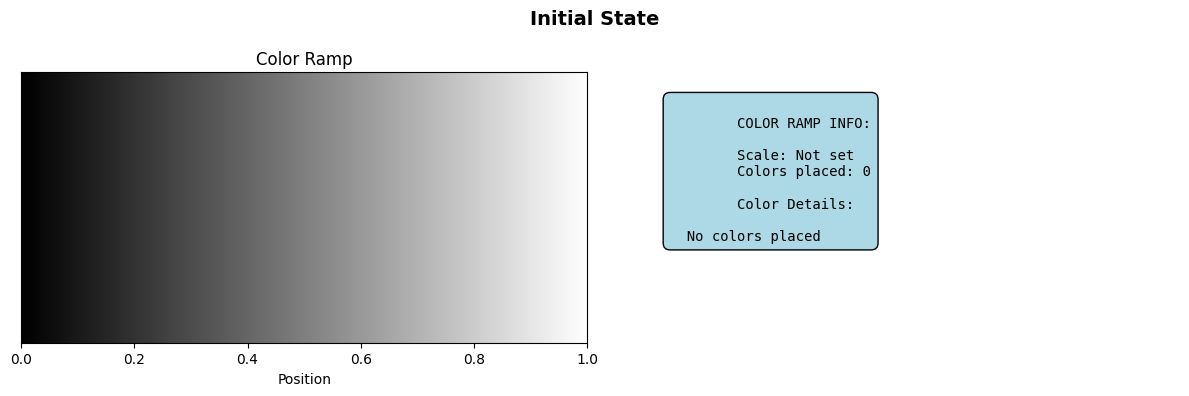

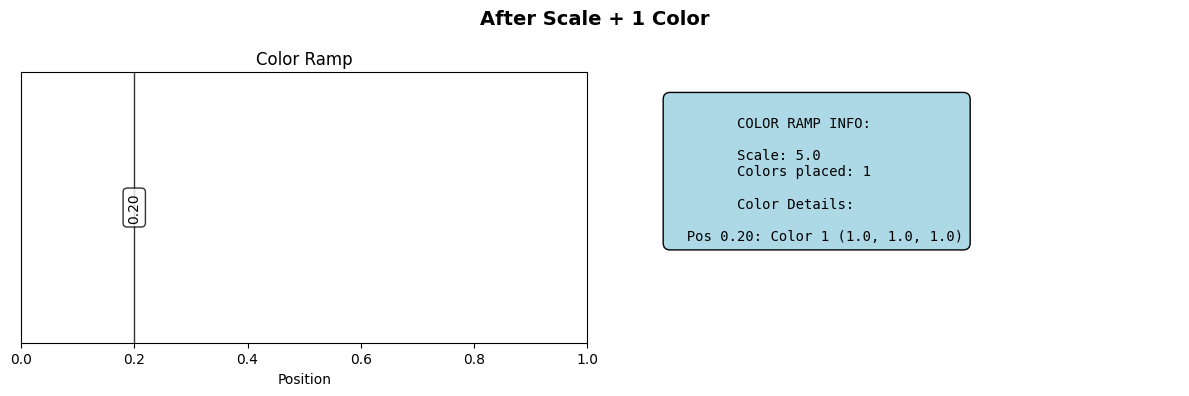

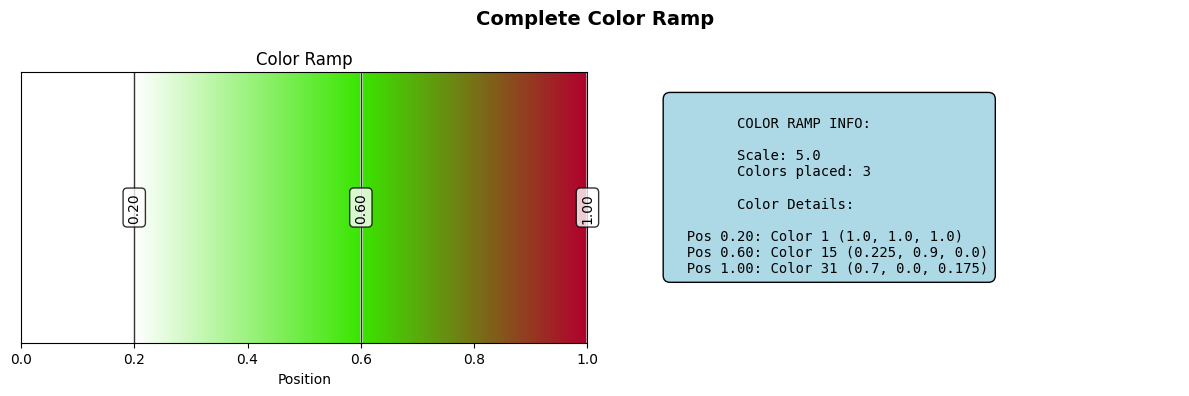

✅ Visualization demo complete!


In [2]:
from blender_gfn_experiment import *
# Example usage functions
def demo_visualization():
    """
    Demonstrate visualization capabilities.

    Example:
        >>> demo_visualization()
    """

    print("🎨 BLENDER VISUALIZATION DEMO")
    print("=" * 50)

    # Create some example states
    from collections import namedtuple

    ColorRampState = namedtuple("ColorRampState", ["scale", "colors", "step_count"])

    # Example states
    state1 = ColorRampState(scale=None, colors={}, step_count=0)
    state2 = ColorRampState(scale=5.0, colors={0: 1}, step_count=2)
    state3 = ColorRampState(scale=5.0, colors={0: 1, 2: 15, 4: 31}, step_count=4)

    print("1. Visualizing color ramp progression...")
    BlenderVisualizationUtility.visualize_color_ramp(state1, "Initial State")
    BlenderVisualizationUtility.visualize_color_ramp(state2, "After Scale + 1 Color")
    BlenderVisualizationUtility.visualize_color_ramp(state3, "Complete Color Ramp")

    print("✅ Visualization demo complete!")


if __name__ == "__main__":
    demo_visualization()

In [4]:
import bpy
import numpy as np
import torch

def get_color_ramp_tensor():
    # Clear scene
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
    
    # Add nodes
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Set up interface
    node_group.interface.new_socket("Geometry", in_out="INPUT", socket_type="NodeSocketGeometry")
    node_group.interface.new_socket("Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry")
    
    # Connect nodes
    node_group.links.new(noise.outputs["Fac"], combine.inputs["X"])
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Y"]) 
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Z"])
    node_group.links.new(combine.outputs["Vector"], ramp.inputs["Fac"])
    node_group.links.new(ramp.outputs["Color"], set_pos.inputs["Offset"])
    node_group.links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    node_group.links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Set color ramp colors
    ramp.color_ramp.elements[0].color = (1, 0, 0, 1)  # Red
    ramp.color_ramp.elements[1].color = (0, 0, 1, 1)  # Blue
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    
    # Add subdivisions for detail
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=6)
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Add geometry nodes modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Force update
    bpy.context.view_layer.update()
    
    # Extract tensor
    depsgraph = bpy.context.evaluated_depsgraph_get()
    evaluated = plane.evaluated_get(depsgraph)
    mesh = evaluated.to_mesh()
    
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    evaluated.to_mesh_clear()
    
    return torch.from_numpy(heights).float()

# Run it
color_tensor = get_color_ramp_tensor()
print(f"Shape: {color_tensor.shape}")
print(f"Range: [{color_tensor.min():.3f}, {color_tensor.max():.3f}]")

Shape: torch.Size([8, 8])
Range: [0.318, 0.619]


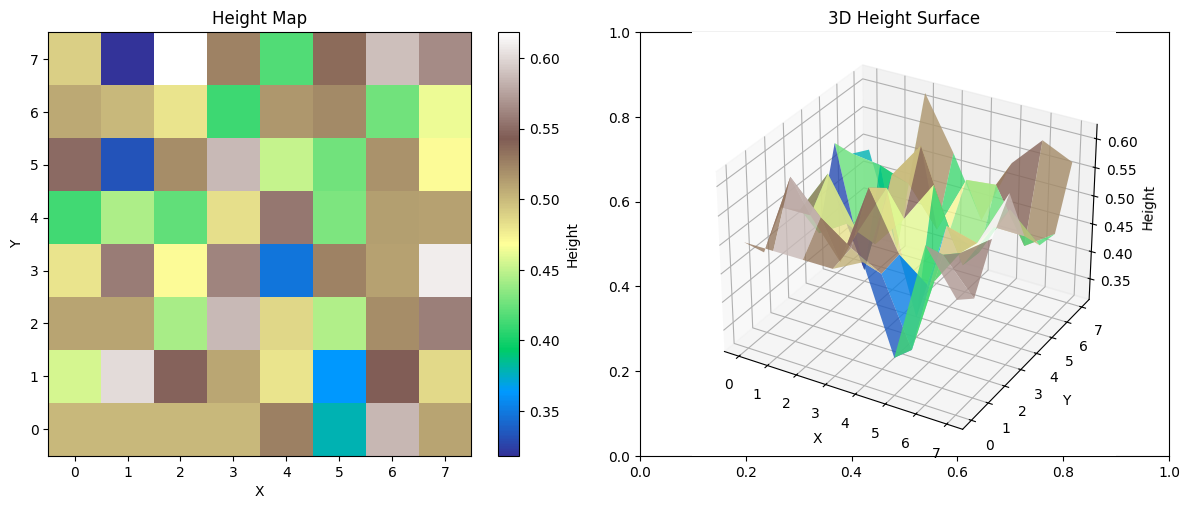

Height Map Statistics:
  Shape: (8, 8)
  Min: 0.318
  Max: 0.619
  Mean: 0.494
  Std: 0.066


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the height map
def visualize_height_map(color_tensor):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Convert to numpy if tensor
    heights = color_tensor.numpy() if hasattr(color_tensor, 'numpy') else color_tensor
    
    # 2D height map
    im1 = ax1.imshow(heights, cmap='terrain', origin='lower')
    ax1.set_title('Height Map')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.colorbar(im1, ax=ax1, label='Height')
    
    # 3D surface
    x = np.arange(heights.shape[1])
    y = np.arange(heights.shape[0])
    X, Y = np.meshgrid(x, y)
    
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, Y, heights, cmap='terrain', alpha=0.8)
    ax2.set_title('3D Height Surface')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y') 
    ax2.set_zlabel('Height')
    
    plt.tight_layout()
    plt.show()
    
    # Print stats
    print(f"Height Map Statistics:")
    print(f"  Shape: {heights.shape}")
    print(f"  Min: {heights.min():.3f}")
    print(f"  Max: {heights.max():.3f}")
    print(f"  Mean: {heights.mean():.3f}")
    print(f"  Std: {heights.std():.3f}")

# Run visualization
visualize_height_map(color_tensor)

🚀 Testing multiple color ramp configurations...

--- Testing Configuration 1: Black to White ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.337, 0.737]

--- Testing Configuration 2: Red to Blue ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.318, 0.619]

--- Testing Configuration 3: Multi-color ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.000, 0.280]

--- Testing Configuration 4: High Contrast ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.088, 0.987]


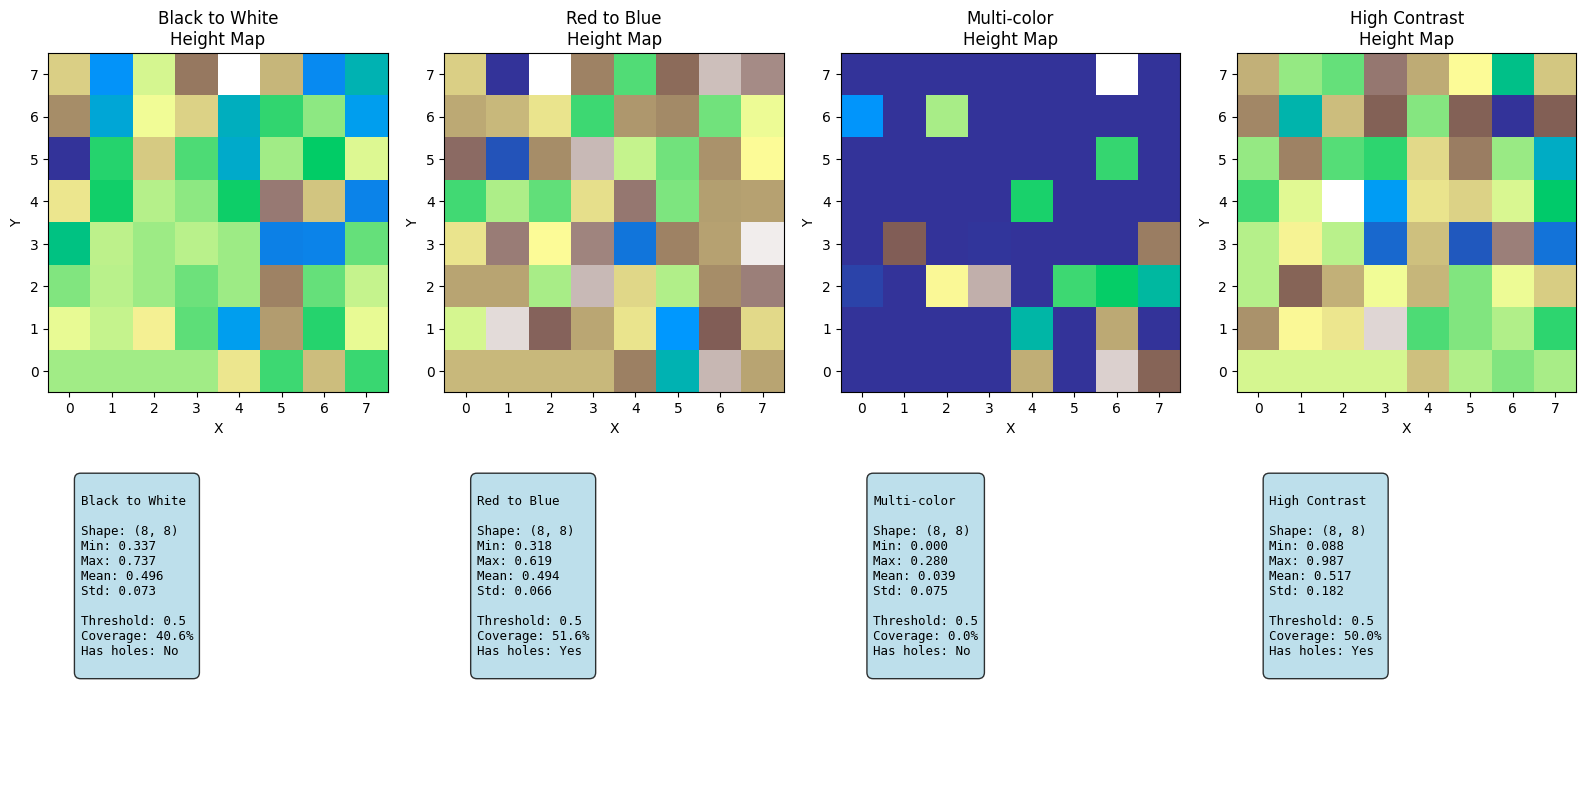


HOLE DETECTION ANALYSIS

Black to White:
  Binary coverage: 40.6%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

Red to Blue:
  Binary coverage: 51.6%
  Holes filled: 5 pixels
  Has holes: YES
  Reward: 0.0

Multi-color:
  Binary coverage: 0.0%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

High Contrast:
  Binary coverage: 50.0%
  Holes filled: 6 pixels
  Has holes: YES
  Reward: 0.0

✅ Completed testing 4 configurations!


In [7]:
import bpy
import numpy as np
import torch
import matplotlib.pyplot as plt

def test_multiple_configurations():
    """Test different color ramp configurations and extract tensors"""
    
    # Configuration 1: Black to White gradient
    config1 = {
        'name': 'Black to White',
        'colors': [(0.0, (0, 0, 0, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 2.0
    }
    
    # Configuration 2: Red to Blue gradient  
    config2 = {
        'name': 'Red to Blue',
        'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 5.0
    }
    
    # Configuration 3: Multi-color gradient
    config3 = {
        'name': 'Multi-color',
        'colors': [(0.0, (1, 0, 0, 1)), (0.5, (0, 1, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 10.0
    }
    
    # Configuration 4: High contrast
    config4 = {
        'name': 'High Contrast',
        'colors': [(0.0, (0, 0, 0, 1)), (0.3, (0, 0, 0, 1)), (0.7, (1, 1, 1, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 8.0
    }
    
    configs = [config1, config2, config3, config4]
    tensors = []
    
    for i, config in enumerate(configs):
        print(f"\n--- Testing Configuration {i+1}: {config['name']} ---")
        tensor = create_and_extract_config(config)
        tensors.append((config['name'], tensor))
        print(f"Extracted tensor shape: {tensor.shape}, range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Visualize all configurations
    visualize_all_configs(tensors)
    
    return tensors

def create_and_extract_config(config):
    """Create scene with specific config and extract tensor"""
    
    # Clear scene
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
    
    # Add nodes
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Set up interface
    node_group.interface.new_socket("Geometry", in_out="INPUT", socket_type="NodeSocketGeometry")
    node_group.interface.new_socket("Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry")
    
    # Connect nodes
    node_group.links.new(noise.outputs["Fac"], combine.inputs["X"])
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Y"]) 
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Z"])
    node_group.links.new(combine.outputs["Vector"], ramp.inputs["Fac"])
    node_group.links.new(ramp.outputs["Color"], set_pos.inputs["Offset"])
    node_group.links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    node_group.links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Set noise scale
    noise.inputs["Scale"].default_value = config['noise_scale']
    
    # Configure color ramp
    color_ramp = ramp.color_ramp
    
    # Clear existing elements (can't remove all, keep at least 2)
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Configure the first two elements
    color_ramp.elements[0].position = config['colors'][0][0]
    color_ramp.elements[0].color = config['colors'][0][1]
    color_ramp.elements[1].position = config['colors'][1][0] 
    color_ramp.elements[1].color = config['colors'][1][1]
    
    # Add additional color stops if needed
    for position, color in config['colors'][2:]:
        element = color_ramp.elements.new(position)
        element.color = color
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=6)
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Add geometry nodes modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Force update
    bpy.context.view_layer.update()
    
    # Extract tensor
    depsgraph = bpy.context.evaluated_depsgraph_get()
    evaluated = plane.evaluated_get(depsgraph)
    mesh = evaluated.to_mesh()
    
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    evaluated.to_mesh_clear()
    
    return torch.from_numpy(heights).float()

def visualize_all_configs(tensors):
    """Visualize all configurations in a grid"""
    
    n_configs = len(tensors)
    fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))
    
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    for i, (name, tensor) in enumerate(tensors):
        heights = tensor.numpy()
        
        # 2D height map
        im1 = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f'{name}\nHeight Map')
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        
        # Statistics plot
        axes[1, i].axis('off')
        
        # Calculate stats
        threshold = 0.5
        binary_mask = heights > threshold
        coverage = (binary_mask.sum() / binary_mask.size) * 100
        
        # Check for holes
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            holes_text = "Yes" if has_holes else "No"
        except ImportError:
            holes_text = "Unknown"
        
        stats_text = f"""
{name}

Shape: {heights.shape}
Min: {heights.min():.3f}
Max: {heights.max():.3f}
Mean: {heights.mean():.3f}
Std: {heights.std():.3f}

Threshold: {threshold}
Coverage: {coverage:.1f}%
Has holes: {holes_text}
"""
        
        axes[1, i].text(0.1, 0.9, stats_text,
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def analyze_hole_detection(tensors):
    """Analyze hole detection for all configurations"""
    
    print("\n" + "="*60)
    print("HOLE DETECTION ANALYSIS")
    print("="*60)
    
    threshold = 0.5
    
    for name, tensor in tensors:
        heights = tensor.numpy()
        binary_mask = heights > threshold
        
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            holes_filled = filled.sum() - binary_mask.sum()
            has_holes = holes_filled > 0
            
            print(f"\n{name}:")
            print(f"  Binary coverage: {(binary_mask.sum() / binary_mask.size) * 100:.1f}%")
            print(f"  Holes filled: {holes_filled} pixels")
            print(f"  Has holes: {'YES' if has_holes else 'NO'}")
            print(f"  Reward: {'0.0' if has_holes else '1.0'}")
            
        except ImportError:
            print(f"\n{name}: scipy not available for hole detection")

# Run the test
print("🚀 Testing multiple color ramp configurations...")
result_tensors = test_multiple_configurations()

# Analyze hole detection
analyze_hole_detection(result_tensors)

print(f"\n✅ Completed testing {len(result_tensors)} configurations!")

🚀 Testing multiple color ramp configurations...

--- Testing Configuration 1: Black to White ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.328, 0.724]

--- Testing Configuration 2: Red to Blue ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.297, 0.707]

--- Testing Configuration 3: Multi-color ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.000, 0.414]

--- Testing Configuration 4: High Contrast ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.500, 0.500]


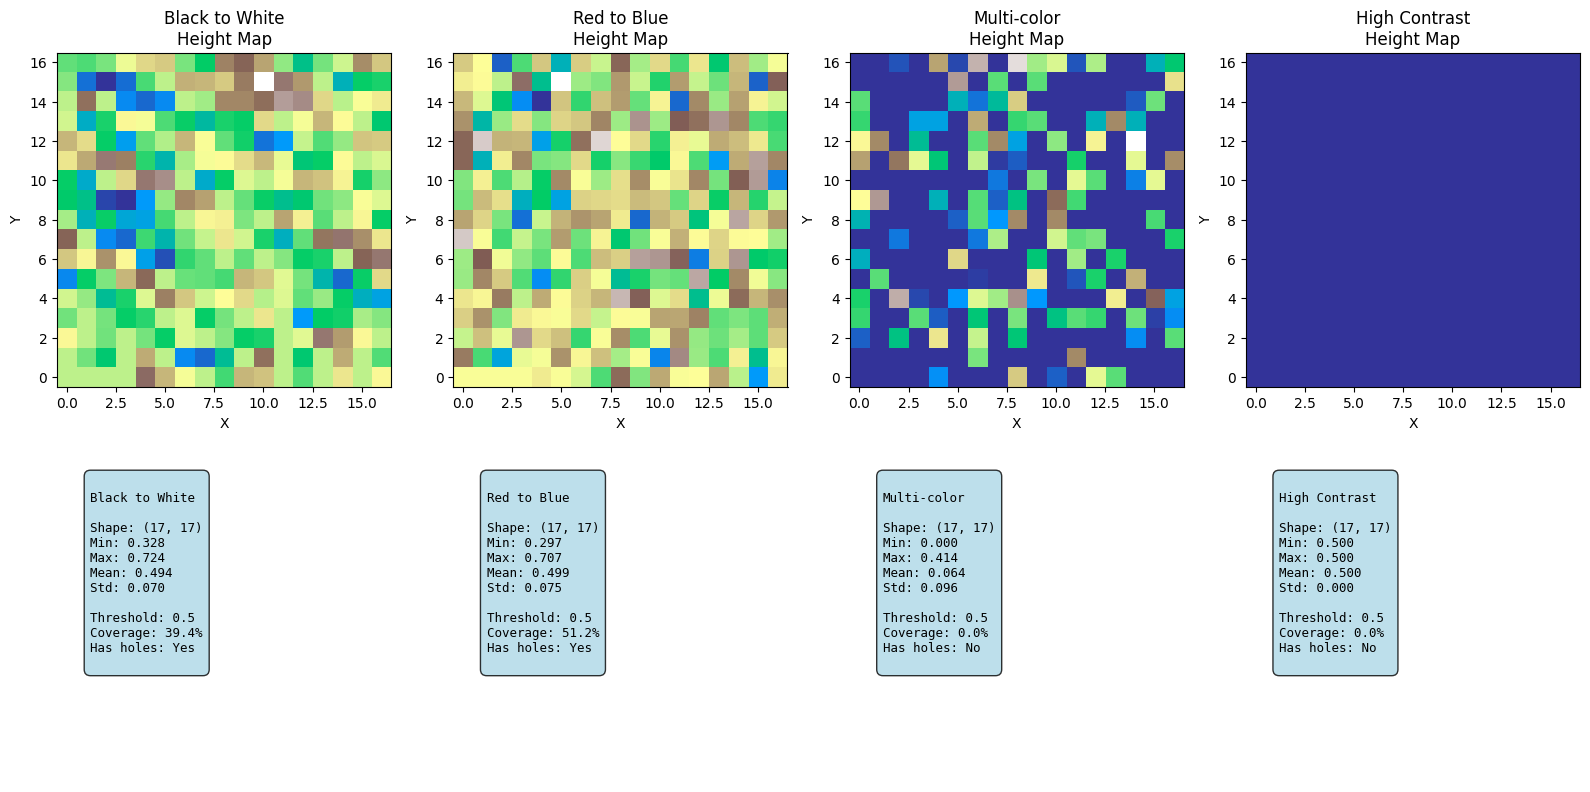


HOLE DETECTION ANALYSIS

Black to White:
  Binary coverage: 39.4%
  Holes filled: 5 pixels
  Has holes: YES
  Reward: 0.0

Red to Blue:
  Binary coverage: 51.2%
  Holes filled: 36 pixels
  Has holes: YES
  Reward: 0.0

Multi-color:
  Binary coverage: 0.0%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

High Contrast:
  Binary coverage: 0.0%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

✅ Completed testing 4 configurations!


In [8]:
import bpy
import numpy as np
import torch
import matplotlib.pyplot as plt

def test_multiple_configurations():
    """Test different color ramp configurations and extract tensors"""
    
    # Configuration 1: Black to White gradient
    config1 = {
        'name': 'Black to White',
        'colors': [(0.0, (0, 0, 0, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 2.0
    }
    
    # Configuration 2: Red to Blue gradient  
    config2 = {
        'name': 'Red to Blue',
        'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 5.0
    }
    
    # Configuration 3: Multi-color gradient
    config3 = {
        'name': 'Multi-color',
        'colors': [(0.0, (1, 0, 0, 1)), (0.5, (0, 1, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 10.0
    }
    
    # Configuration 4: High contrast
    config4 = {
        'name': 'High Contrast',
        'colors': [(0.0, (0, 0, 0, 1)), (0.3, (0, 0, 0, 1)), (0.7, (1, 1, 1, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 8.0
    }
    
    configs = [config1, config2, config3, config4]
    tensors = []
    
    for i, config in enumerate(configs):
        print(f"\n--- Testing Configuration {i+1}: {config['name']} ---")
        tensor = create_and_extract_config(config)
        tensors.append((config['name'], tensor))
        print(f"Extracted tensor shape: {tensor.shape}, range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Visualize all configurations
    visualize_all_configs(tensors)
    
    return tensors

def create_and_extract_config(config):
    """Create scene with specific config and extract tensor"""
    
    # Clear scene
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
    
    # Add nodes
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Set up interface
    node_group.interface.new_socket("Geometry", in_out="INPUT", socket_type="NodeSocketGeometry")
    node_group.interface.new_socket("Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry")
    
    # Connect nodes
    node_group.links.new(noise.outputs["Fac"], combine.inputs["X"])
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Y"]) 
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Z"])
    node_group.links.new(combine.outputs["Vector"], ramp.inputs["Fac"])
    node_group.links.new(ramp.outputs["Color"], set_pos.inputs["Offset"])
    node_group.links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    node_group.links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Set noise scale
    noise.inputs["Scale"].default_value = config['noise_scale']
    
    # Configure color ramp
    color_ramp = ramp.color_ramp
    
    # Clear existing elements (can't remove all, keep at least 2)
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Configure the first two elements
    color_ramp.elements[0].position = config['colors'][0][0]
    color_ramp.elements[0].color = config['colors'][0][1]
    color_ramp.elements[1].position = config['colors'][1][0] 
    color_ramp.elements[1].color = config['colors'][1][1]
    
    # Add additional color stops if needed
    for position, color in config['colors'][2:]:
        element = color_ramp.elements.new(position)
        element.color = color
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    
    # Add more subdivisions for higher detail
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=15)  # 16x16 grid instead of 8x8
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Add geometry nodes modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Force update
    bpy.context.view_layer.update()
    
    # Extract tensor
    depsgraph = bpy.context.evaluated_depsgraph_get()
    evaluated = plane.evaluated_get(depsgraph)
    mesh = evaluated.to_mesh()
    
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    evaluated.to_mesh_clear()
    
    return torch.from_numpy(heights).float()

def visualize_all_configs(tensors):
    """Visualize all configurations in a grid"""
    
    n_configs = len(tensors)
    fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))
    
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    for i, (name, tensor) in enumerate(tensors):
        heights = tensor.numpy()
        
        # 2D height map
        im1 = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f'{name}\nHeight Map')
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        
        # Statistics plot
        axes[1, i].axis('off')
        
        # Calculate stats
        threshold = 0.5
        binary_mask = heights > threshold
        coverage = (binary_mask.sum() / binary_mask.size) * 100
        
        # Check for holes
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            holes_text = "Yes" if has_holes else "No"
        except ImportError:
            holes_text = "Unknown"
        
        stats_text = f"""
{name}

Shape: {heights.shape}
Min: {heights.min():.3f}
Max: {heights.max():.3f}
Mean: {heights.mean():.3f}
Std: {heights.std():.3f}

Threshold: {threshold}
Coverage: {coverage:.1f}%
Has holes: {holes_text}
"""
        
        axes[1, i].text(0.1, 0.9, stats_text,
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def analyze_hole_detection(tensors):
    """Analyze hole detection for all configurations"""
    
    print("\n" + "="*60)
    print("HOLE DETECTION ANALYSIS")
    print("="*60)
    
    threshold = 0.5
    
    for name, tensor in tensors:
        heights = tensor.numpy()
        binary_mask = heights > threshold
        
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            holes_filled = filled.sum() - binary_mask.sum()
            has_holes = holes_filled > 0
            
            print(f"\n{name}:")
            print(f"  Binary coverage: {(binary_mask.sum() / binary_mask.size) * 100:.1f}%")
            print(f"  Holes filled: {holes_filled} pixels")
            print(f"  Has holes: {'YES' if has_holes else 'NO'}")
            print(f"  Reward: {'0.0' if has_holes else '1.0'}")
            
        except ImportError:
            print(f"\n{name}: scipy not available for hole detection")

# Run the test
print("🚀 Testing multiple color ramp configurations...")
result_tensors = test_multiple_configurations()

# Analyze hole detection
analyze_hole_detection(result_tensors)

print(f"\n✅ Completed testing {len(result_tensors)} configurations!")

✅ Blender available

🧪 Test 1: Creating Environment
🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7

🎨 Testing ColorUtilities:
Position 2 of 5: 60.0%
Color ID 2: RGBA(r=1.0, g=0.0, b=0.0, a=1.0)
Color name: Red

🔧 Test 2: Creating Blender Procedure
Created plane: Plane
Available nodes: ['noise', 'ramp']

🎛️ Updating procedure parameters...
Parameters updated!

📊 Extracting terrain tensor...
Extracted tensor shape: torch.Size([17, 17])
Tensor range: [0.379, 0.633]

🏆 Testing reward calculation...
Has holes: True
Reward: 0.0

🧪 Test 3: Testing Multiple Configurations

--- Config 1: Red-Blue ---
  Shape: torch.Size([17, 17])
  Range: [0.345, 0.604]
  Reward: 1.0
  Has holes: False

--- Config 2: Green-Yellow ---
  Shape: torch.Size([17, 17])
  Range: [0.000, 0.000]
  Reward: 1.0
  Has holes: False

--- Config 3: Multi-color ---
  Shape: torch.Size([17, 17])
  Range: [0.083, 0.290]
  Reward: 1.0
  Has holes: False

📊 Visualizing Results...


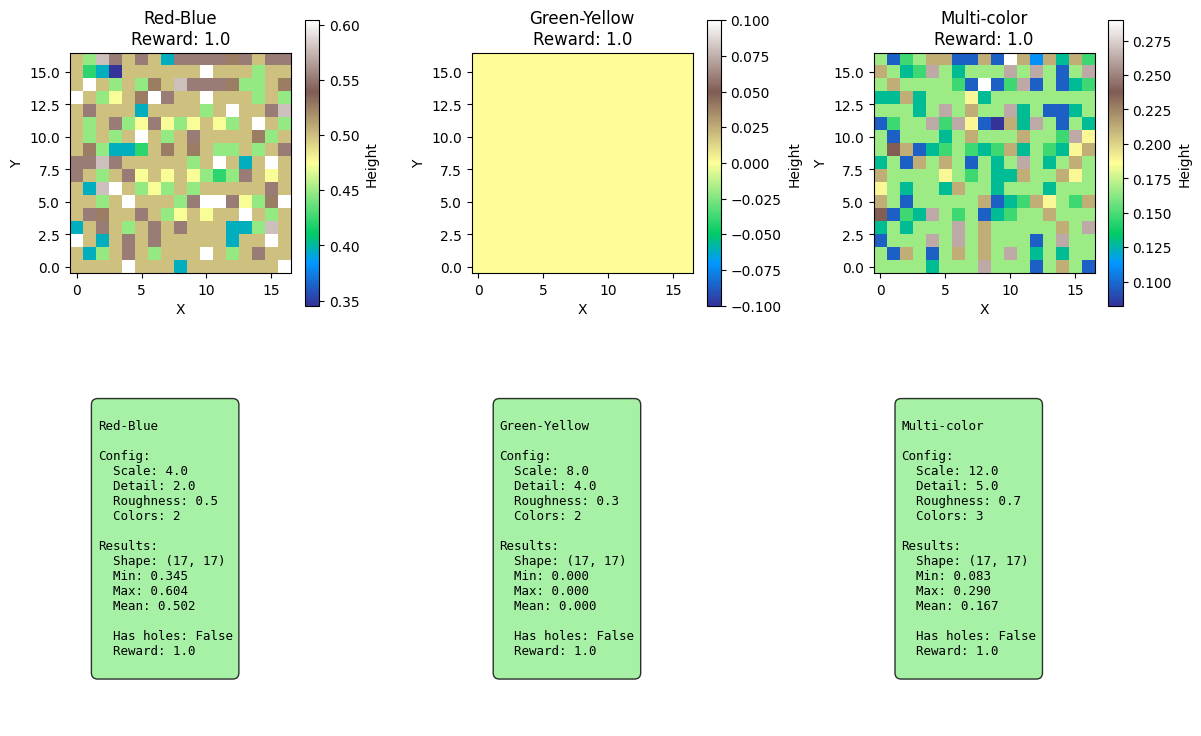


🧪 Test 5: Testing Environment State Methods

📋 State Translation Visualization:
BLENDER STATE TRANSLATION PREVIEW
Noise Scale: 5.0

Color Ramp Configuration:
  Custom Colors:
    40.0% (0.400) -> Red (1.0, 0.0, 0.0, 1.0)
    80.0% (0.800) -> Blue (0.0, 0.0, 1.0, 1.0)

Summary: Color Ramp: 40.0% Red, 80.0% Blue

🔍 Debug Information:
❌ Debug info not available (Blender not connected)
Debug info requires env.connect_blender() to be called first

🎯 TEST SUMMARY
Environment created: ✅
ColorUtilities working: ✅
Blender available: ✅
Procedure creation: ✅
Parameter updates: ✅
Tensor extraction: ✅
Reward calculation: ✅
Configurations tested: 3
State visualization: ✅
Debug utilities: ✅

🚀 All tests completed!

📖 QUICK USAGE EXAMPLE

# Create environment
env = BlenderColorRampEnvironment()

# Create procedure (once)
plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()

# Test different configs
config = {
    'noise_scale': 5.0,
    'noise_detail': 3.0,
    'noise_roughness': 0.6,
  

In [2]:
# ================================================================
# Notebook Test for Blender ColorRamp Environment
# ================================================================

import numpy as np
import torch
import matplotlib.pyplot as plt

# Import your environment
from blender_gfn_experiment import BlenderColorRampEnvironment

# Test if Blender is available
try:
    import bpy
    print("✅ Blender available")
    BLENDER_AVAILABLE = True
except ImportError:
    print("❌ Blender not available - will simulate")
    BLENDER_AVAILABLE = False

# ================================================================
# Test 1: Create Environment and Test Utilities
# ================================================================

print("\n🧪 Test 1: Creating Environment")
env = BlenderColorRampEnvironment(max_colors=5, num_color_choices=32)

# Test ColorUtilities
print("\n🎨 Testing ColorUtilities:")
pos = env.ColorUtilities.calculate_position(2, 5)
print(f"Position 2 of 5: {pos:.1%}")

rgba = env.ColorUtilities.color_id_to_rgba(2)  # Red
print(f"Color ID 2: {rgba}")

name = env.ColorUtilities.get_color_name(2)
print(f"Color name: {name}")

# ================================================================
# Test 2: Test Blender Procedure Creation (if available)
# ================================================================

if BLENDER_AVAILABLE:
    print("\n🔧 Test 2: Creating Blender Procedure")
    
    # Create the procedure
    plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
    print(f"Created plane: {plane.name}")
    print(f"Available nodes: {list(nodes.keys())}")
    
    # Test config
    test_config = {
        'noise_scale': 5.0,
        'noise_detail': 3.0,
        'noise_roughness': 0.6,
        'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))]  # Red to Blue
    }
    
    # Update parameters
    print("\n🎛️ Updating procedure parameters...")
    env.BlenderUtilities.update_procedure_parameters(nodes, test_config)
    print("Parameters updated!")
    
    # Extract tensor
    print("\n📊 Extracting terrain tensor...")
    tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
    print(f"Extracted tensor shape: {tensor.shape}")
    print(f"Tensor range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Test reward calculation
    print("\n🏆 Testing reward calculation...")
    has_holes = env.RewardUtilities.detect_holes(tensor)
    reward = env.RewardUtilities.compute_reward(tensor)
    print(f"Has holes: {has_holes}")
    print(f"Reward: {reward}")

else:
    print("\n⚠️ Skipping Blender tests - not available")

# ================================================================
# Test 3: Test Multiple Configurations
# ================================================================

def test_multiple_configs():
    """Test different configurations"""
    
    configs = [
        {
            'name': 'Red-Blue',
            'noise_scale': 4.0,
            'noise_detail': 2.0,
            'noise_roughness': 0.5,
            'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))]
        },
        {
            'name': 'Green-Yellow',
            'noise_scale': 8.0,
            'noise_detail': 4.0,
            'noise_roughness': 0.3,
            'colors': [(0.0, (0, 1, 0, 1)), (1.0, (1, 1, 0, 1))]
        },
        {
            'name': 'Multi-color',
            'noise_scale': 12.0,
            'noise_detail': 5.0,
            'noise_roughness': 0.7,
            'colors': [(0.0, (1, 0, 0, 1)), (0.5, (0, 1, 0, 1)), (1.0, (0, 0, 1, 1))]
        }
    ]
    
    results = []
    
    if BLENDER_AVAILABLE:
        print("\n🧪 Test 3: Testing Multiple Configurations")
        
        for i, config in enumerate(configs):
            print(f"\n--- Config {i+1}: {config['name']} ---")
            
            # Create fresh procedure
            plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
            
            # Update with config
            env.BlenderUtilities.update_procedure_parameters(nodes, config)
            
            # Extract tensor
            tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
            
            # Calculate metrics
            reward = env.RewardUtilities.compute_reward(tensor)
            has_holes = env.RewardUtilities.detect_holes(tensor)
            
            result = {
                'name': config['name'],
                'tensor': tensor,
                'reward': reward,
                'has_holes': has_holes,
                'config': config
            }
            results.append(result)
            
            print(f"  Shape: {tensor.shape}")
            print(f"  Range: [{tensor.min():.3f}, {tensor.max():.3f}]")
            print(f"  Reward: {reward}")
            print(f"  Has holes: {has_holes}")
    
    return results

# Run multi-config test
test_results = test_multiple_configs()

# ================================================================
# Test 4: Visualization
# ================================================================

def visualize_results(results):
    """Visualize the test results"""
    
    if not results:
        print("No results to visualize")
        return
    
    n_configs = len(results)
    fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))
    
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    for i, result in enumerate(results):
        tensor = result['tensor']
        heights = tensor.numpy() if torch.is_tensor(tensor) else tensor
        
        # Height map
        im = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f"{result['name']}\nReward: {result['reward']}")
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        plt.colorbar(im, ax=axes[0, i], label='Height', shrink=0.8)
        
        # Stats
        axes[1, i].axis('off')
        
        config = result['config']
        stats_text = f"""
{result['name']}

Config:
  Scale: {config['noise_scale']}
  Detail: {config['noise_detail']}
  Roughness: {config['noise_roughness']}
  Colors: {len(config['colors'])}

Results:
  Shape: {heights.shape}
  Min: {heights.min():.3f}
  Max: {heights.max():.3f}
  Mean: {heights.mean():.3f}
  
  Has holes: {result['has_holes']}
  Reward: {result['reward']}
"""
        
        color = 'lightgreen' if result['reward'] > 0 else 'lightcoral'
        axes[1, i].text(0.1, 0.9, stats_text,
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Visualize results
if test_results:
    print("\n📊 Visualizing Results...")
    visualize_results(test_results)

# ================================================================
# Test 5: Test State Visualization (Environment Methods)
# ================================================================

print("\n🧪 Test 5: Testing Environment State Methods")

# Create a test state
from blender_gfn_experiment import ColorRampState, ColorID

test_state = ColorRampState(
    scale=5.0,
    colors={1: ColorID.RED, 3: ColorID.BLUE}
)

# Test state visualization
print("\n📋 State Translation Visualization:")
translation = env.visualize_state_translation(test_state)
print(translation)

# Test debug info
print("\n🔍 Debug Information:")
debug_info = env.debug_state_translation(test_state)

if debug_info:
    print(f"Scale: {debug_info['scale']}")
    print(f"Number of colors: {debug_info['num_colors']}")
    print(f"Blender ready: {debug_info['blender_ready']}")
    
    for pos, info in debug_info['color_positions'].items():
        print(f"Position {pos}: {info['color_name']} at {info['normalized_position']:.1%}")
else:
    print("❌ Debug info not available (Blender not connected)")
    print("Debug info requires env.connect_blender() to be called first")

# ================================================================
# Summary
# ================================================================

print("\n" + "="*60)
print("🎯 TEST SUMMARY")
print("="*60)
print(f"Environment created: ✅")
print(f"ColorUtilities working: ✅")
print(f"Blender available: {'✅' if BLENDER_AVAILABLE else '❌'}")

if BLENDER_AVAILABLE:
    print(f"Procedure creation: ✅")
    print(f"Parameter updates: ✅")
    print(f"Tensor extraction: ✅")
    print(f"Reward calculation: ✅")
    print(f"Configurations tested: {len(test_results)}")

print(f"State visualization: ✅")
print(f"Debug utilities: ✅")

print("\n🚀 All tests completed!")

# ================================================================
# Quick Usage Example
# ================================================================

print("\n" + "="*60)
print("📖 QUICK USAGE EXAMPLE")
print("="*60)

example_code = '''
# Create environment
env = BlenderColorRampEnvironment()

# Create procedure (once)
plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()

# Test different configs
config = {
    'noise_scale': 5.0,
    'noise_detail': 3.0,
    'noise_roughness': 0.6,
    'colors': [(0.0, (1,0,0,1)), (1.0, (0,0,1,1))]
}

# Update parameters
env.BlenderUtilities.update_procedure_parameters(nodes, config)

# Extract results
tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
reward = env.RewardUtilities.compute_reward(tensor)

print(f"Tensor shape: {tensor.shape}")
print(f"Reward: {reward}")
'''

print(example_code)

🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7
🔗 Connected to Blender
🧪 Testing Reward Function with Visualization

--- Test 1 ---
Scale: 2.0
Colors: Color Ramp: 40.0% Red, 80.0% Blue
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 2 ---
Scale: 5.0
Colors: Color Ramp: 20.0% Black, 100.0% White
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 3 ---
Scale: 10.0
Colors: Color Ramp: 40.0% Green, 60.0% Yellow, 80.0% Cyan
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 4 ---
Scale: 15.0
Colors: Color Ramp: 20.0% Magenta, 60.0% Green
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 5 ---
Scale: 20.0
Colors: Color Ramp: 40.0% Blue, 100.0% Red
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]


/tmp/ipykernel_645021/960689879.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jpleona/jpleona_c/bpygfn/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


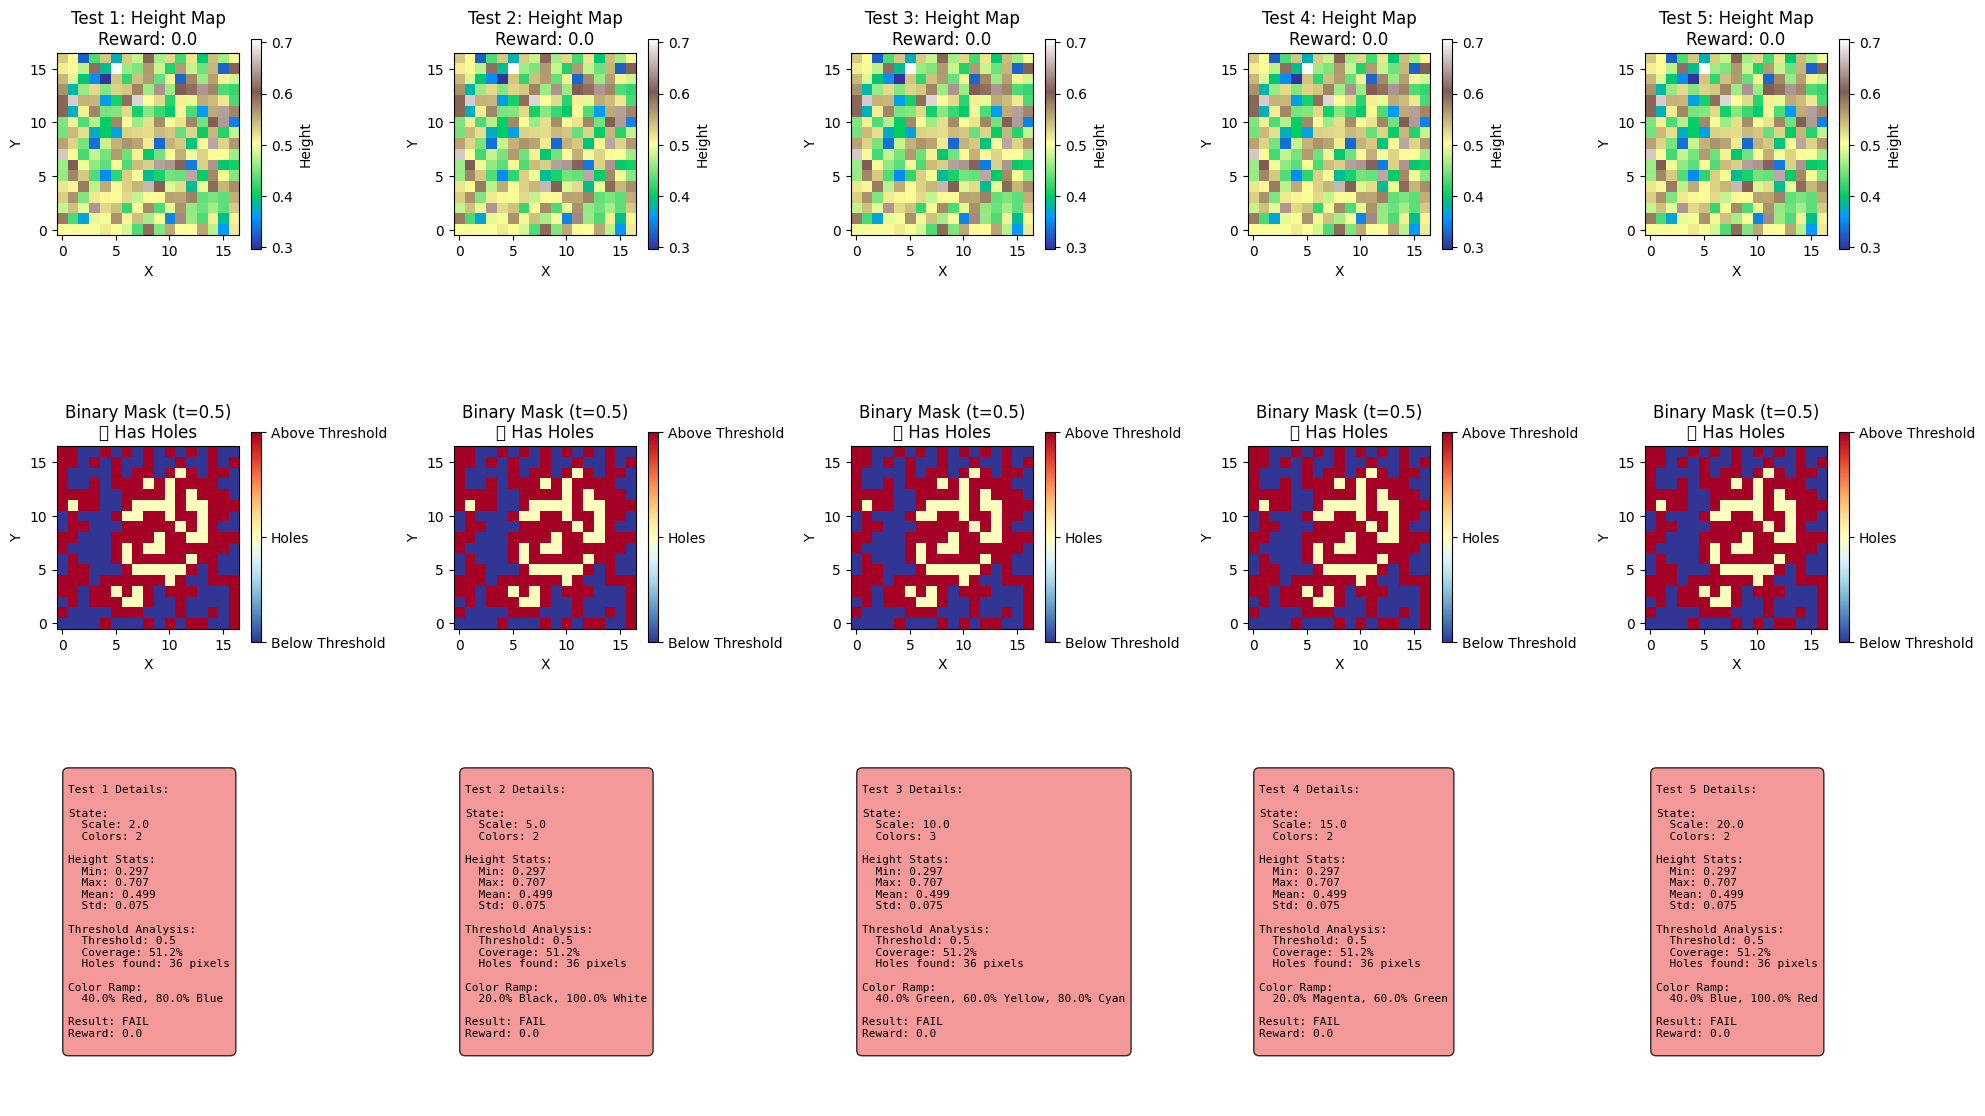


🔍 Detailed Red-Blue Test


/tmp/ipykernel_645021/960689879.py:225: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/jpleona/jpleona_c/bpygfn/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


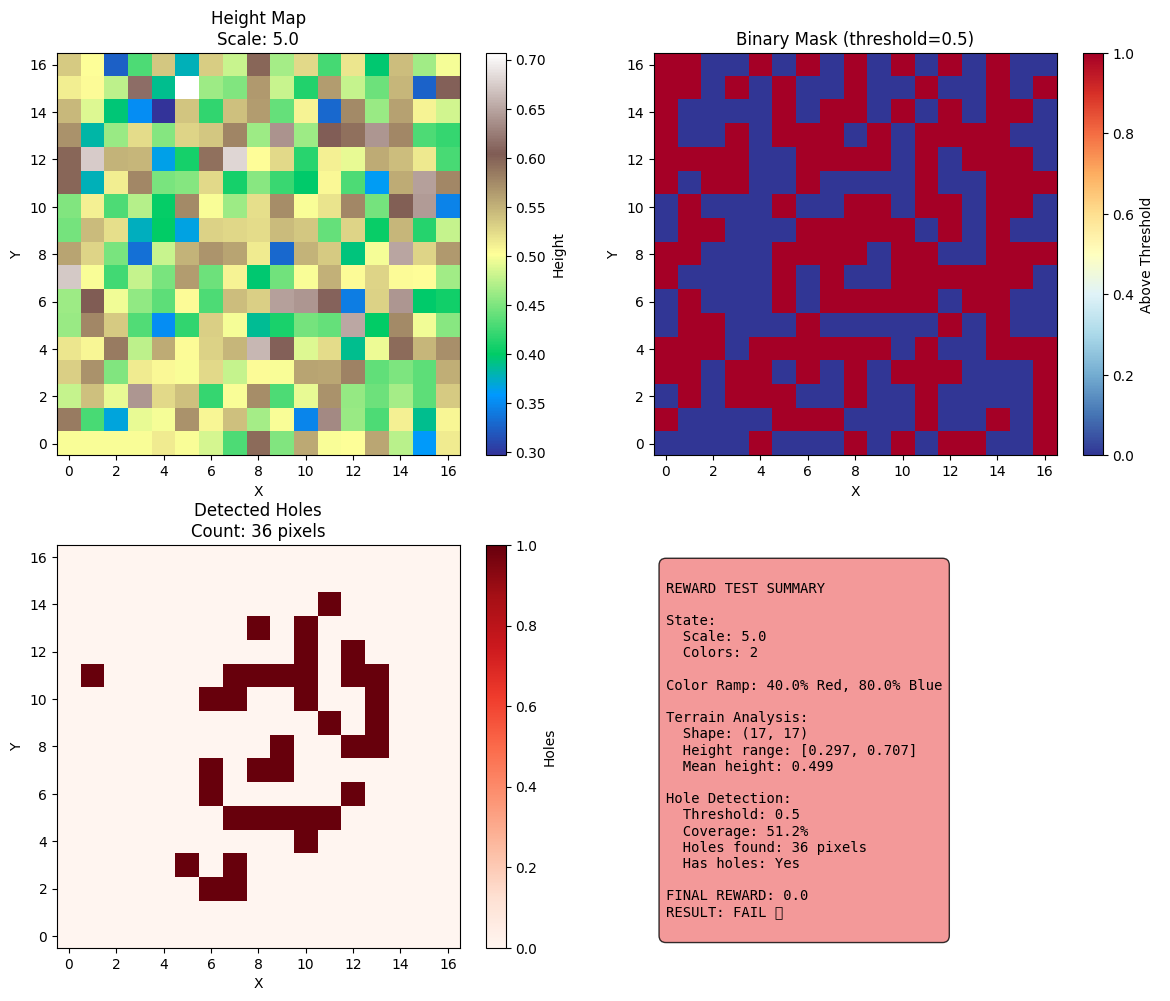

Reward: 0.0
Result: FAIL

🎯 Tested 5 configurations!
Success rate: 0/5 (0.0%)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from blender_gfn_experiment import BlenderColorRampEnvironment, ColorRampState, ColorID

def test_reward_with_visualization(env):
    """Test reward function with comprehensive visualization"""
    
    # Setup once
    plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
    env.connect_blender(plane, None, nodes)
    
    # Test different states
    test_states = [
        ColorRampState(scale=2.0, colors={1: ColorID.RED, 3: ColorID.BLUE}),
        ColorRampState(scale=5.0, colors={0: ColorID.BLACK, 4: ColorID.WHITE}),
        ColorRampState(scale=10.0, colors={1: ColorID.GREEN, 2: ColorID.YELLOW, 3: ColorID.CYAN}),
        ColorRampState(scale=15.0, colors={0: ColorID.MAGENTA, 2: ColorID.GREEN}),
        ColorRampState(scale=20.0, colors={1: ColorID.BLUE, 4: ColorID.RED})
    ]
    
    results = []
    
    print("🧪 Testing Reward Function with Visualization")
    print("=" * 60)
    
    for i, state in enumerate(test_states):
        print(f"\n--- Test {i+1} ---")
        
        # Get reward
        reward = env.get_reward(state)
        
        # Extract tensor for visualization
        tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
        
        # Get state description
        description = env.ColorUtilities.describe_color_ramp(state.colors, env.max_colors)
        
        result = {
            'state': state,
            'tensor': tensor,
            'reward': reward,
            'description': description
        }
        results.append(result)
        
        print(f"Scale: {state.scale}")
        print(f"Colors: {description}")
        print(f"Reward: {reward}")
        print(f"Tensor shape: {tensor.shape}")
        print(f"Height range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Create comprehensive visualization
    visualize_reward_results(results)
    
    return results

def visualize_reward_results(results):
    """Create comprehensive visualization of reward results"""
    
    n_tests = len(results)
    fig, axes = plt.subplots(3, n_tests, figsize=(4*n_tests, 12))
    
    if n_tests == 1:
        axes = axes.reshape(3, 1)
    
    for i, result in enumerate(results):
        tensor = result['tensor']
        heights = tensor.numpy() if hasattr(tensor, 'numpy') else tensor
        reward = result['reward']
        state = result['state']
        
        # Row 1: Height map
        im1 = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f"Test {i+1}: Height Map\nReward: {reward}")
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        plt.colorbar(im1, ax=axes[0, i], label='Height', shrink=0.6)
        
        # Row 2: Binary mask and hole detection
        threshold = 0.5
        binary_mask = heights > threshold
        
        # Detect holes
        filled = ndimage.binary_fill_holes(binary_mask)
        holes_mask = filled & ~binary_mask
        
        # Show binary mask with holes highlighted
        display_mask = binary_mask.astype(float)
        display_mask[holes_mask] = 0.5  # Gray for holes
        
        im2 = axes[1, i].imshow(display_mask, cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1)
        axes[1, i].set_title(f"Binary Mask (t={threshold})\n{'✅ No Holes' if reward > 0 else '❌ Has Holes'}")
        axes[1, i].set_xlabel('X')
        axes[1, i].set_ylabel('Y')
        
        # Add colorbar
        cbar = plt.colorbar(im2, ax=axes[1, i], shrink=0.6)
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(['Below Threshold', 'Holes', 'Above Threshold'])
        
        # Row 3: Statistics and info
        axes[2, i].axis('off')
        
        # Calculate detailed stats
        coverage = (binary_mask.sum() / binary_mask.size) * 100
        holes_count = holes_mask.sum()
        
        info_text = f"""
Test {i+1} Details:

State:
  Scale: {state.scale}
  Colors: {len(state.colors)}

Height Stats:
  Min: {heights.min():.3f}
  Max: {heights.max():.3f}
  Mean: {heights.mean():.3f}
  Std: {heights.std():.3f}

Threshold Analysis:
  Threshold: {threshold}
  Coverage: {coverage:.1f}%
  Holes found: {holes_count} pixels
  
Color Ramp:
  {result['description'].replace('Color Ramp: ', '')}

Result: {'SUCCESS' if reward > 0 else 'FAIL'}
Reward: {reward}
"""
        
        color = 'lightgreen' if reward > 0 else 'lightcoral'
        axes[2, i].text(0.05, 0.95, info_text,
                        transform=axes[2, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def visualize_single_reward_test(env, state, title="Reward Test"):
    """Detailed visualization for a single state"""
    
    print(f"\n🔍 {title}")
    print("=" * 40)
    
    # Get reward and tensor
    reward = env.get_reward(state)
    tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
    heights = tensor.numpy() if hasattr(tensor, 'numpy') else tensor
    
    # Create detailed visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Height map
    im1 = ax1.imshow(heights, cmap='terrain', origin='lower')
    ax1.set_title(f'Height Map\nScale: {state.scale}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.colorbar(im1, ax=ax1, label='Height')
    
    # 2. Binary mask
    threshold = 0.5
    binary_mask = heights > threshold
    im2 = ax2.imshow(binary_mask, cmap='RdYlBu_r', origin='lower')
    ax2.set_title(f'Binary Mask (threshold={threshold})')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    plt.colorbar(im2, ax=ax2, label='Above Threshold')
    
    # 3. Hole detection
    filled = ndimage.binary_fill_holes(binary_mask)
    holes_mask = filled & ~binary_mask
    
    im3 = ax3.imshow(holes_mask, cmap='Reds', origin='lower')
    ax3.set_title(f'Detected Holes\nCount: {holes_mask.sum()} pixels')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im3, ax=ax3, label='Holes')
    
    # 4. Summary
    ax4.axis('off')
    
    description = env.ColorUtilities.describe_color_ramp(state.colors, env.max_colors)
    coverage = (binary_mask.sum() / binary_mask.size) * 100
    
    summary_text = f"""
REWARD TEST SUMMARY

State:
  Scale: {state.scale}
  Colors: {len(state.colors)}
  
{description}

Terrain Analysis:
  Shape: {heights.shape}
  Height range: [{heights.min():.3f}, {heights.max():.3f}]
  Mean height: {heights.mean():.3f}
  
Hole Detection:
  Threshold: {threshold}
  Coverage: {coverage:.1f}%
  Holes found: {holes_mask.sum()} pixels
  Has holes: {'Yes' if holes_mask.sum() > 0 else 'No'}

FINAL REWARD: {reward}
RESULT: {'SUCCESS ✅' if reward > 0 else 'FAIL ❌'}
"""
    
    color = 'lightgreen' if reward > 0 else 'lightcoral'
    ax4.text(0.05, 0.95, summary_text,
             transform=ax4.transAxes,
             verticalalignment='top',
             fontfamily='monospace',
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.5", 
                     facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Reward: {reward}")
    print(f"Result: {'SUCCESS' if reward > 0 else 'FAIL'}")

# Example usage
if __name__ == "__main__":
    # Create environment
    env = BlenderColorRampEnvironment()
    
    # Test multiple states
    results = test_reward_with_visualization(env)
    
    # Test single state in detail
    test_state = ColorRampState(scale=5.0, colors={1: ColorID.RED, 3: ColorID.BLUE})
    visualize_single_reward_test(env, test_state, "Detailed Red-Blue Test")
    
    print(f"\n🎯 Tested {len(results)} configurations!")
    success_count = sum(1 for r in results if r['reward'] > 0)
    print(f"Success rate: {success_count}/{len(results)} ({success_count/len(results)*100:.1f}%)")

In [4]:
print(reward)

0.0


🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7
🧪 Testing Reward Function with Visualization

--- Test 1 ---
🔗 Connected to Blender
Scale: 1.0
Colors: Color Ramp: 20.0% Black, 100.0% White
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 2 ---
🔗 Connected to Blender
Scale: 8.0
Colors: Color Ramp: 40.0% Red, 80.0% Blue
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 3 ---
🔗 Connected to Blender
Scale: 25.0
Colors: Color Ramp: 20.0% Green, 40.0% Yellow, 60.0% Cyan, 80.0% Magenta
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 4 ---
🔗 Connected to Blender
Scale: 50.0
Colors: Color Ramp: 20.0% Blue, 100.0% Red
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 5 ---
🔗 Connected to Blender
Scale: 75.0
Colors: Color Ramp: 40.0% Generated-15, 60.0% Generated-25, 80.0% Generated-31
Reward: 0.0
Tenso

/tmp/ipykernel_647029/4112029238.py:145: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jpleona/jpleona_c/bpygfn/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


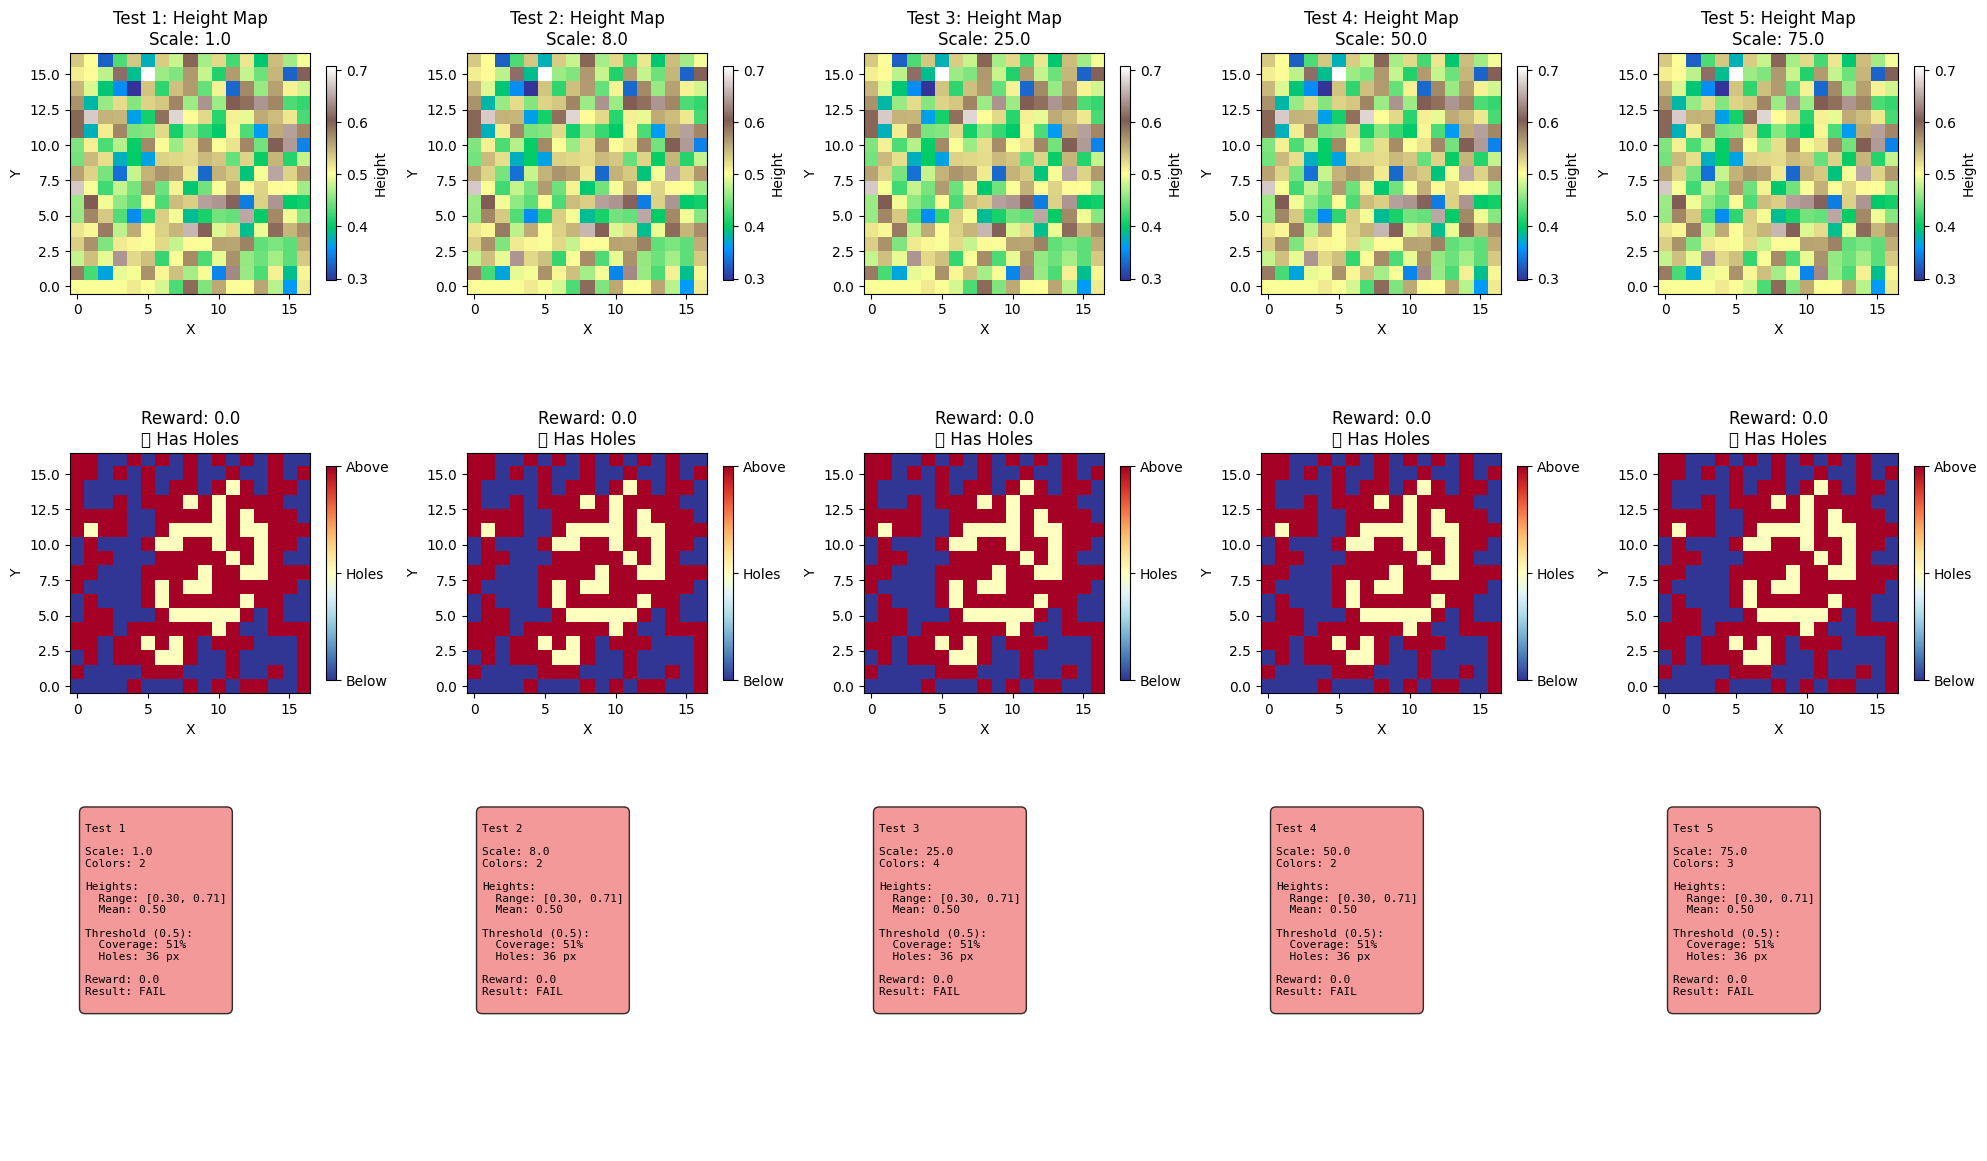


🔍 Detailed Red-Blue Test


/tmp/ipykernel_647029/4112029238.py:227: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/jpleona/jpleona_c/bpygfn/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


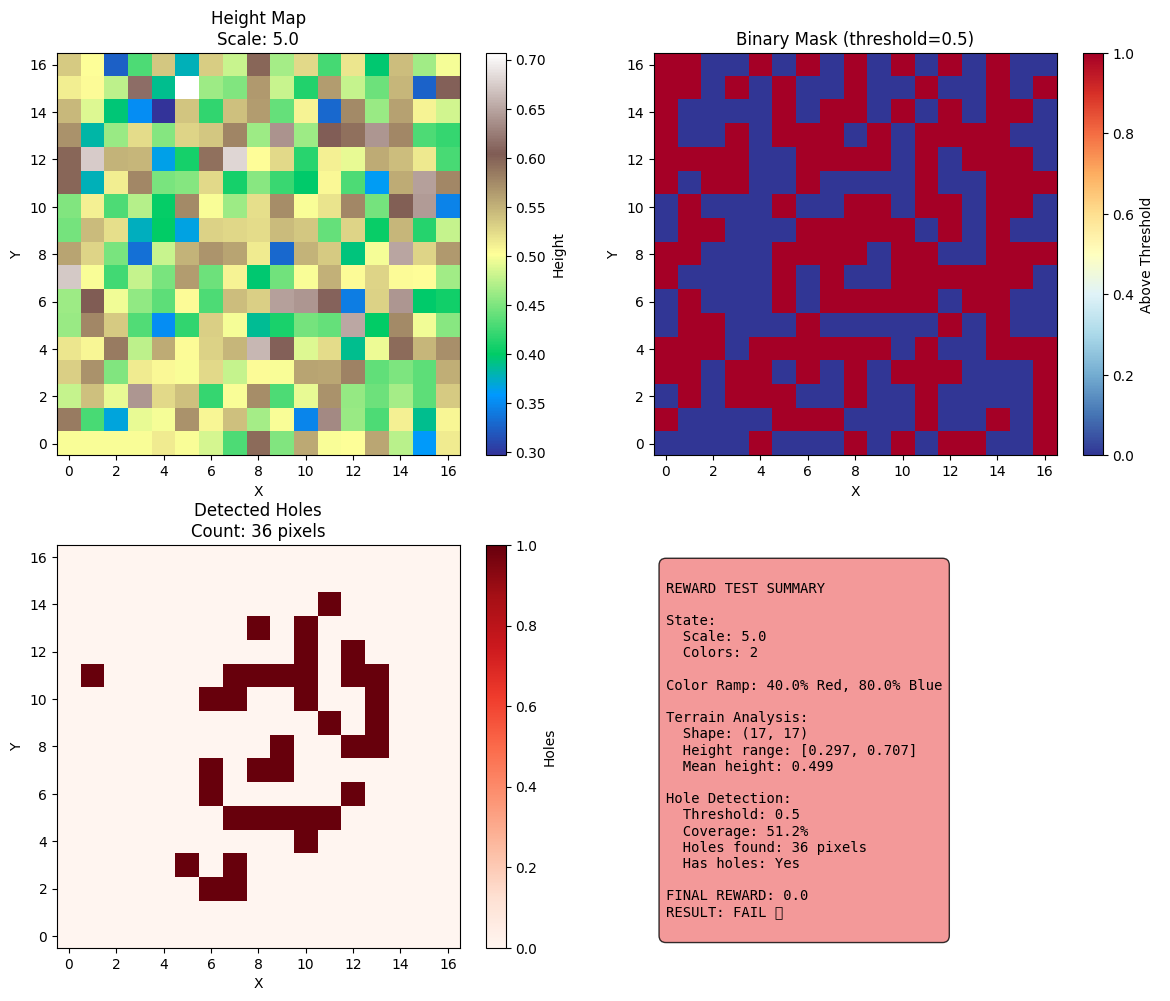

Reward: 0.0
Result: FAIL

🎯 Tested 5 configurations!
Success rate: 0/5 (0.0%)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from blender_gfn_experiment import BlenderColorRampEnvironment, ColorRampState, ColorID

def test_reward_with_visualization(env):
    """Test reward function with comprehensive visualization"""
    
    # Test different states with varied parameters
    test_states = [
        # Low scale, simple gradient
        ColorRampState(scale=1.0, colors={0: ColorID.BLACK, 4: ColorID.WHITE}),
        
        # Medium scale, contrasting colors
        ColorRampState(scale=8.0, colors={1: ColorID.RED, 3: ColorID.BLUE}),
        
        # High scale, dense colors
        ColorRampState(scale=25.0, colors={0: ColorID.GREEN, 1: ColorID.YELLOW, 2: ColorID.CYAN, 3: ColorID.MAGENTA}),
        
        # Very high scale, sparse colors
        ColorRampState(scale=50.0, colors={0: ColorID.BLUE, 4: ColorID.RED}),
        
        # Extreme scale, procedural colors
        ColorRampState(scale=75.0, colors={1: 15, 2: 25, 3: 31})  # Procedural color IDs
    ]
    
    results = []
    
    print("🧪 Testing Reward Function with Visualization")
    print("=" * 60)
    
    for i, state in enumerate(test_states):
        print(f"\n--- Test {i+1} ---")
        
        # Create FRESH procedure for each test
        plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
        env.connect_blender(plane, None, nodes)
        
        # Get reward
        reward = env.get_reward(state)
        
        # Extract tensor for visualization
        tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
        
        # Get state description
        description = env.ColorUtilities.describe_color_ramp(state.colors, env.max_colors)
        
        result = {
            'state': state,
            'tensor': tensor,
            'reward': reward,
            'description': description
        }
        results.append(result)
        
        print(f"Scale: {state.scale}")
        print(f"Colors: {description}")
        print(f"Reward: {reward}")
        print(f"Tensor shape: {tensor.shape}")
        print(f"Height range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Create comprehensive visualization
    visualize_reward_results(results)
    
    return results

def visualize_reward_results(results):
    """Create comprehensive visualization of reward results"""
    
    n_tests = len(results)
    fig, axes = plt.subplots(3, n_tests, figsize=(4*n_tests, 12))
    
    if n_tests == 1:
        axes = axes.reshape(3, 1)
    
    for i, result in enumerate(results):
        tensor = result['tensor']
        heights = tensor.numpy() if hasattr(tensor, 'numpy') else tensor
        reward = result['reward']
        state = result['state']
        
        # Row 1: Height map
        im1 = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f"Test {i+1}: Height Map\nScale: {state.scale}")
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        plt.colorbar(im1, ax=axes[0, i], label='Height', shrink=0.6)
        
        # Row 2: Binary mask and hole detection
        threshold = 0.5
        binary_mask = heights > threshold
        
        # Detect holes
        filled = ndimage.binary_fill_holes(binary_mask)
        holes_mask = filled & ~binary_mask
        
        # Show binary mask with holes highlighted
        display_mask = binary_mask.astype(float)
        display_mask[holes_mask] = 0.5  # Gray for holes
        
        im2 = axes[1, i].imshow(display_mask, cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1)
        axes[1, i].set_title(f"Reward: {reward}\n{'✅ No Holes' if reward > 0 else '❌ Has Holes'}")
        axes[1, i].set_xlabel('X')
        axes[1, i].set_ylabel('Y')
        
        # Add colorbar
        cbar = plt.colorbar(im2, ax=axes[1, i], shrink=0.6)
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(['Below', 'Holes', 'Above'])
        
        # Row 3: Statistics and info
        axes[2, i].axis('off')
        
        # Calculate detailed stats
        coverage = (binary_mask.sum() / binary_mask.size) * 100
        holes_count = holes_mask.sum()
        
        info_text = f"""
Test {i+1}

Scale: {state.scale}
Colors: {len(state.colors)}

Heights:
  Range: [{heights.min():.2f}, {heights.max():.2f}]
  Mean: {heights.mean():.2f}

Threshold (0.5):
  Coverage: {coverage:.0f}%
  Holes: {holes_count} px
  
Reward: {reward}
Result: {'PASS' if reward > 0 else 'FAIL'}
"""
        
        color = 'lightgreen' if reward > 0 else 'lightcoral'
        axes[2, i].text(0.05, 0.95, info_text,
                        transform=axes[2, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def visualize_single_reward_test(env, state, title="Reward Test"):
    """Detailed visualization for a single state"""
    
    print(f"\n🔍 {title}")
    print("=" * 40)
    
    # Get reward and tensor
    reward = env.get_reward(state)
    tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
    heights = tensor.numpy() if hasattr(tensor, 'numpy') else tensor
    
    # Create detailed visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Height map
    im1 = ax1.imshow(heights, cmap='terrain', origin='lower')
    ax1.set_title(f'Height Map\nScale: {state.scale}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.colorbar(im1, ax=ax1, label='Height')
    
    # 2. Binary mask
    threshold = 0.5
    binary_mask = heights > threshold
    im2 = ax2.imshow(binary_mask, cmap='RdYlBu_r', origin='lower')
    ax2.set_title(f'Binary Mask (threshold={threshold})')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    plt.colorbar(im2, ax=ax2, label='Above Threshold')
    
    # 3. Hole detection
    filled = ndimage.binary_fill_holes(binary_mask)
    holes_mask = filled & ~binary_mask
    
    im3 = ax3.imshow(holes_mask, cmap='Reds', origin='lower')
    ax3.set_title(f'Detected Holes\nCount: {holes_mask.sum()} pixels')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im3, ax=ax3, label='Holes')
    
    # 4. Summary
    ax4.axis('off')
    
    description = env.ColorUtilities.describe_color_ramp(state.colors, env.max_colors)
    coverage = (binary_mask.sum() / binary_mask.size) * 100
    
    summary_text = f"""
REWARD TEST SUMMARY

State:
  Scale: {state.scale}
  Colors: {len(state.colors)}
  
{description}

Terrain Analysis:
  Shape: {heights.shape}
  Height range: [{heights.min():.3f}, {heights.max():.3f}]
  Mean height: {heights.mean():.3f}
  
Hole Detection:
  Threshold: {threshold}
  Coverage: {coverage:.1f}%
  Holes found: {holes_mask.sum()} pixels
  Has holes: {'Yes' if holes_mask.sum() > 0 else 'No'}

FINAL REWARD: {reward}
RESULT: {'SUCCESS ✅' if reward > 0 else 'FAIL ❌'}
"""
    
    color = 'lightgreen' if reward > 0 else 'lightcoral'
    ax4.text(0.05, 0.95, summary_text,
             transform=ax4.transAxes,
             verticalalignment='top',
             fontfamily='monospace',
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.5", 
                     facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Reward: {reward}")
    print(f"Result: {'SUCCESS' if reward > 0 else 'FAIL'}")

# Example usage
if __name__ == "__main__":
    # Create environment
    env = BlenderColorRampEnvironment()
    
    # Test multiple states
    results = test_reward_with_visualization(env)
    
    # Test single state in detail
    test_state = ColorRampState(scale=5.0, colors={1: ColorID.RED, 3: ColorID.BLUE})
    visualize_single_reward_test(env, test_state, "Detailed Red-Blue Test")
    
    print(f"\n🎯 Tested {len(results)} configurations!")
    success_count = sum(1 for r in results if r['reward'] > 0)
    print(f"Success rate: {success_count}/{len(results)} ({success_count/len(results)*100:.1f}%)")